# 1. Setup

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


ModuleNotFoundError: No module named 'kerastuner'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Datasets Sources

Dataset Sources:
https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset
https://www.kaggle.com/datasets/thedrcat/daigt-v3-train-dataset
https://www.kaggle.com/datasets/alejopaullier/daigt-external-dataset
https://www.kaggle.com/datasets/nbroad/persaude-corpus-2
https://www.kaggle.com/datasets/nbroad/daigt-data-llama-70b-and-falcon180b
https://www.kaggle.com/datasets/radek1/llm-generated-essays
https://www.kaggle.com/datasets/darraghdog/hello-claude-1000-essays-from-anthropic
https://www.kaggle.com/datasets/kingki19/llm-generated-essay-using-palm-from-google-gen-ai
https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data
https://www.kaggle.com/competitions/feedback-prize-english-language-learning/data
https://www.kaggle.com/datasets/japkeeratsingh/ielts-writing
https://github.com/yafuly/DeepfakeTextDetect
https://huggingface.co/datasets/qwedsacf/ivypanda-essays
https://huggingface.co/datasets/nid989/EssayFroum-Dataset
https://huggingface.co/datasets/whateverweird17/essay_grade_v1
https://huggingface.co/datasets/dim/essayforum_raw_writing_10k
https://huggingface.co/datasets/ChristophSchuhmann/essays-with-instructions
https://huggingface.co/datasets/whateverweird17/essay_grade_v2
https://www.kaggle.com/datasets/starblasters8/human-vs-llm-text-corpus/code

Please find the complete merged dataset here as it is too big for github: https://drive.google.com/file/d/1QRM8sHJIHuOrn9vNRIoB3FG6EVO3J11Q/view?usp=sharing


GPT-4 small test dataset sources: [Wikipedia](https://www.wikipedia.org/) and GPT-4 generated texts.


## 3. Loading Datasets

In [ ]:
# Load the dataset and display 5 first rows
path = './dataset/data.csv'
data = pd.read_csv(path)

data.head()

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",Bloom-7B,0,967,157
1,Miles feels restless after working all day. He...,Bloom-7B,0,5068,778
2,So first of I am danish. That means that I fol...,Bloom-7B,0,1602,267
3,In this paper we present a novel rule-based ap...,Bloom-7B,0,5469,848
4,"Most social progressives, love democracy, and ...",Bloom-7B,0,2379,380


In [5]:
# This is the preprocessed a data so I didn't have to go through the preprocessing step every time I ran the notebook
path = '/content/drive/MyDrive/cleaned_data.csv'
data = pd.read_csv(path)

data.head()

,text,label,cleaned_text
0,"Federal law supersedes state law, and cannabis...",1,federal law supersedes state law cannabis medi...
1,Miles feels restless after working all day. He...,1,mile feel restless working day decides go park...
2,So first of I am danish. That means that I fol...,1,first danish mean follow american politics muc...
3,In this paper we present a novel rule-based ap...,1,paper present novel rulebased approach runtime...
4,"Most social progressives, love democracy, and ...",1,social progressive love democracy relatively l...


# 5. Text preprocessing

In [6]:
#turning dataset into panda DataFrame
df = pd.DataFrame(data)

In [7]:
# dropping rows with null values
df = df.dropna()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)
    text = re.sub(r'\$\\?[a-zA-Z]+|\$|\\', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply function to text column
df['cleaned_text'] =df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brotz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brotz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Cap text length to reduce outliers
lower_cap = df['text_length'].quantile(0.05)
upper_cap = df['text_length'].quantile(0.95)
df['text_length'] = np.clip(df['text_length'], lower_cap, upper_cap)


In [ ]:
# initialise X and y variables (to be used in the classifier algos)

y=df['label']
X=df['cleaned_text']

# 6. Exploring the Dataset / Features

In [ ]:
# Print number of rows in df
num_rows = df.shape[0]

print(f"Number of rows in df: {num_rows}")
print(f"Number of rows in merged_df: {num_rows}")

Number of rows in df: 788922
Number of rows in merged_df: 854260


In [ ]:
# Turns strings identifying specific LLM into 0 for Human and 1 for AI, this will be a binary classification task
df['source'] = df['source'].apply(lambda x: 0 if 'Human' in x else 1)

df

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",1,0,967,157
1,Miles feels restless after working all day. He...,1,0,5068,778
2,So first of I am danish. That means that I fol...,1,0,1602,267
3,In this paper we present a novel rule-based ap...,1,0,5469,848
4,"Most social progressives, love democracy, and ...",1,0,2379,380
...,...,...,...,...,...
788917,"\nIn the vast expanse of time, where the echoe...",1,1293,5523,870
788918,"\nThe phenomenon of brain drain, particularly ...",1,1154,4540,677
788919,\nThe Influence of Climate Change on Marine Ec...,1,2783,3889,598
788920,\nTitle: The Case for Limiting Car Usage: Navi...,1,41,3560,533


In [ ]:
# Drop columns
drop_columns = ['prompt_id', 'text_length', 'word_count']
df = df.drop(columns=drop_columns)

# Renaming the 'source' column to 'label'
df = df.rename(columns={'source': 'label'})

df


,text,label
0,"Federal law supersedes state law, and cannabis...",1
1,Miles feels restless after working all day. He...,1
2,So first of I am danish. That means that I fol...,1
3,In this paper we present a novel rule-based ap...,1
4,"Most social progressives, love democracy, and ...",1
...,...,...
788917,"\nIn the vast expanse of time, where the echoe...",1
788918,"\nThe phenomenon of brain drain, particularly ...",1
788919,\nThe Influence of Climate Change on Marine Ec...,1
788920,\nTitle: The Case for Limiting Car Usage: Navi...,1


label
1    441230
0    347692
Name: count, dtype: int64


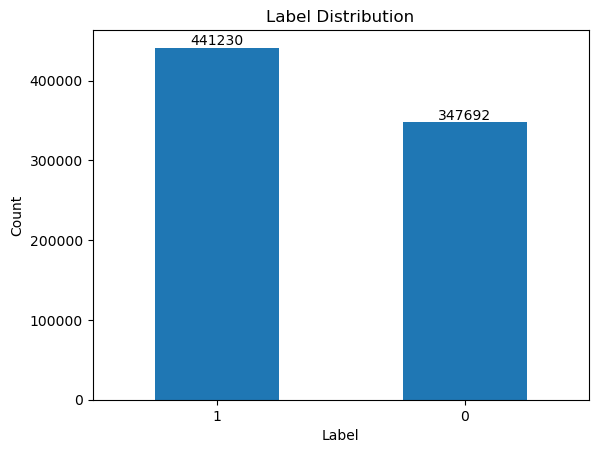

In [ ]:
# Calculate and print value counts
label_counts = df['label'].value_counts()

print(label_counts)

# plotting bar chart
label_counts.plot.bar()
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# text annotations
for index, value in enumerate(label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')


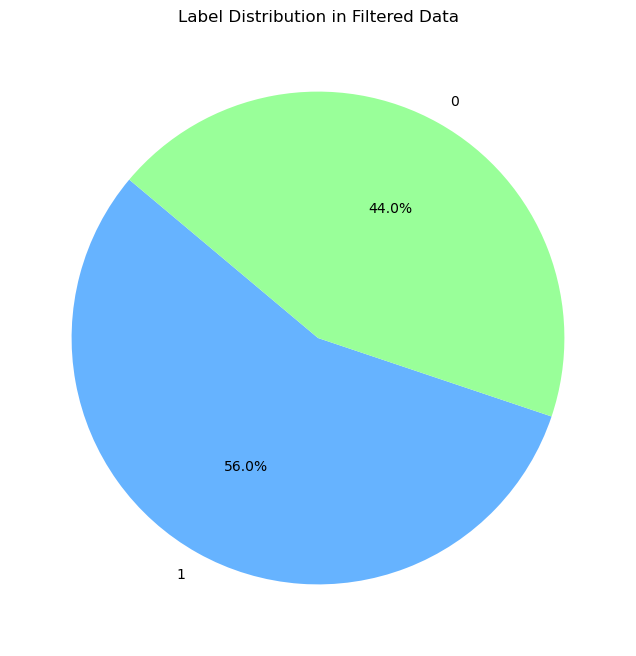

In [ ]:
# generate label distribution pie chart
label_counts = filtered_df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('label distribution')
plt.show()

[('also', 485349), ('one', 485146), ('people', 476903), ('time', 366518), ('would', 326951), ('new', 307031), ('company', 278152), ('life', 268262), ('work', 261125), ('student', 256983)]


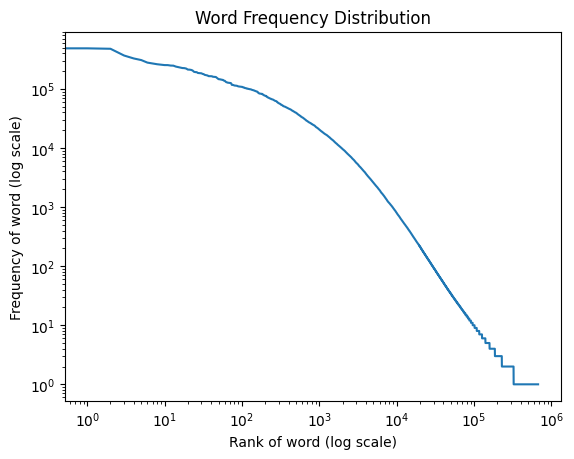

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# initialising tokenizer with 50000 words
tokenizer = Tokenizer(num_words=50000)

# Fit tokenizer
tokenizer.fit_on_texts(df['cleaned_text'])

# getting word count
wordCounts = tokenizer.word_counts

# sort word counts
sortedWordCounts = sorted(wordCounts.items(), key=lambda x: x[1], reverse=True)

# most common words
print(sortedWordCounts[:10])

# Distribution
import matplotlib.pyplot as plt
counts = [count for word, count in sortedWordCounts]
plt.plot(counts)
plt.xscale('log')
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.show()

Distribution of Sequence Lengths:
Length 0 to 100: 131605 sequences
Length 100 to 200: 64369 sequences
Length 200 to 300: 49711 sequences
Length 300 to 400: 45779 sequences
Length 400 to 500: 19440 sequences
Length 500 to 600: 10097 sequences
Length 600 to 700: 6523 sequences
Length 700 to 800: 4670 sequences
Length 800 to 900: 3729 sequences
Length 900 to 1000: 2737 sequences
Length 1000 to 1100: 2158 sequences
Length 1100 to 1200: 1948 sequences
Length 1200 to 1300: 1692 sequences
Length 1300 to 1400: 1358 sequences
Length 1400 to 1500: 1165 sequences
Length 1500 to 1600: 1059 sequences
Length 1600 to 1700: 939 sequences
Length 1700 to 1800: 751 sequences
Length 1800 to 1900: 547 sequences
Length 1900 to 2000: 430 sequences
Length 2000 to 2100: 364 sequences
Length 2100 to 2200: 275 sequences
Length 2200 to 2300: 245 sequences
Length 2300 to 2400: 222 sequences
Length 2400 to 2500: 181 sequences
Length 2500 to 2600: 134 sequences
Length 2600 to 2700: 115 sequences
Length 2700 to 2800

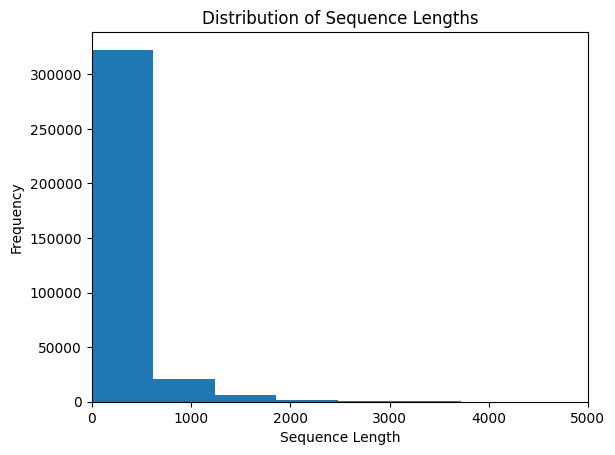

In [ ]:
# Calculate  length of all sequences
sequence_lengths = [len(seq) for seq in X]

# define bins
bins = np.arange(0, 5001, 100)  # Bins from 0 to 5000 with a step of 100

# calculate the histogram
hist, bin_edges = np.histogram(sequence_lengths, bins=bins)

# Print the distribution
print("Distribution of Sequence Lengths:")
for i in range(len(hist)):
    print(f"Length {bin_edges[i]} to {bin_edges[i+1]}: {hist[i]} sequences")

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlim(0, 5000)  # Set the x-axis limit to 5000
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [ ]:
df.dtypes

text            object
label            int64
cleaned_text    object
dtype: object

In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


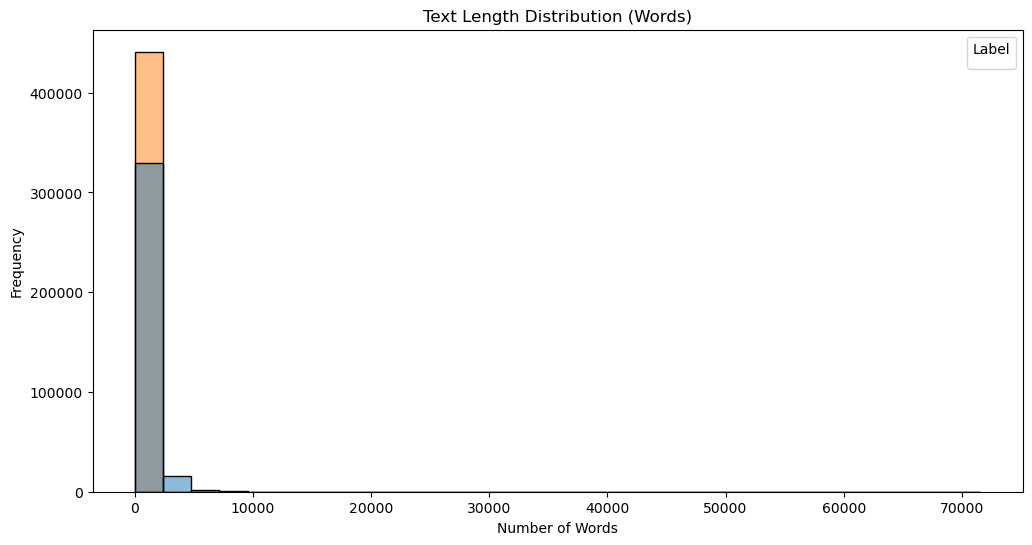

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='text_length', hue='label', kde=False, bins=30)

plt.title('Text Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(title='Label')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


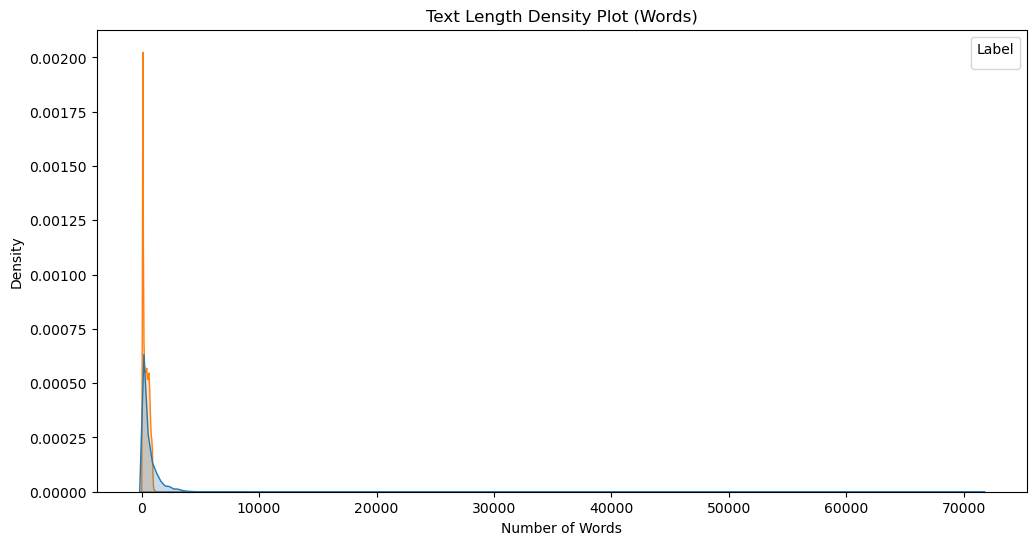

In [ ]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data=df, x='text_length', hue='label', fill=True)

plt.title('Text Length Density Plot (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend(title='Label')
plt.show()


In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Filter the dataset to exclude texts longer than 10,000 words
filtered_df = df[df['text_length'] <= 10000]

# display the number of records before and after filtering
print(f"Number of records before filtering: {len(df)}")
print(f"Number of records after filtering: {len(filtered_df)}")

Number of records before filtering: 788919
Number of records after filtering: 788590


In [ ]:
# Calculating text length by number of characters and words
df['text_length_chars'] = df['text'].apply(len)
df['text_length_words'] = df['text'].apply(lambda x: len(x.split()))

# Grouping by label to calculate statistics
chars = df.groupby('label')['text_length_chars'].describe()
words = df.groupby('label')['text_length_words'].describe()

# Print the tables
print("Text Length by Number of Characters:\n", chars)
print("\nText Length by Number of Words:\n", words)

Text Length by Number of Characters:
           count         mean          std    min    25%     50%     75%  \
label                                                                     
0      347692.0  4474.216111  6989.088147  110.0  892.0  2288.0  5421.0   
1      441227.0  2058.900491  1726.088477  105.0  494.0  1664.0  3420.0   

            max  
label            
0      890119.0  
1       54288.0  

Text Length by Number of Words:
           count        mean          std   min    25%    50%    75%      max
label                                                                       
0      347692.0  710.334687  1003.480562  25.0  152.0  396.0  884.0  71543.0
1      441227.0  330.649237   268.515677  25.0   86.0  278.0  536.0   9418.0


In [ ]:

longest_text = df.loc[df['text_length_words'].idxmax()]

print("Longest text by number of words:\n", longest_text)

Longest text by number of words:
 text                 E-Sale Contract From an Islamic Perspective Es...
label                                                                0
cleaned_text         esale contract islamic perspective essay abstr...
text_length_words                                                71543
text_length_chars                                               432950
Name: 227088, dtype: object


In [ ]:
# dividehuman and AI text
human = ' '.join(filtered_df[filtered_df['label'] == 0]['cleaned_text'])
ai = ' '.join(filtered_df[filtered_df['label'] == 1]['cleaned_text'])

# word frequencies
human_wordsf = Counter(human.split())
ai_wordsf = Counter(ai.split())

# most common words
human_common = human_words.most_common(20)
ai_common = ai_words.most_common(20)

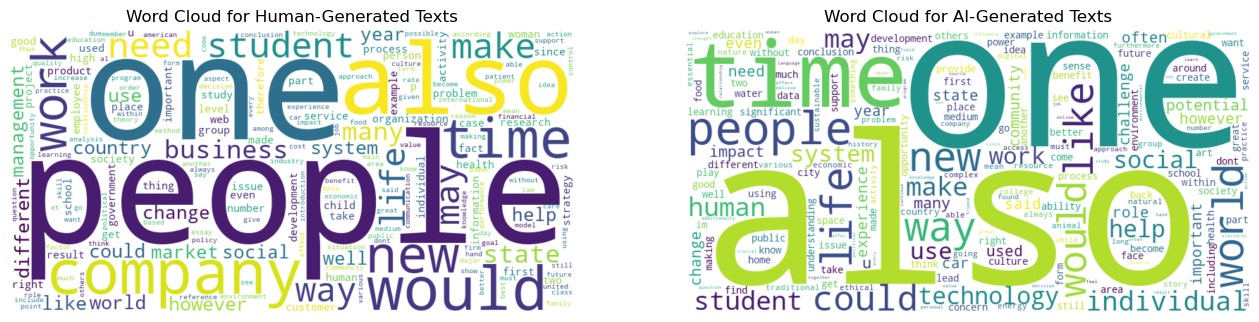

In [ ]:
from wordcloud import WordCloud

# word clouds
human_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(human_wordsf)
ai_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ai_wordsf)

# plot
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(human_cloud, interpolation='bilinear')
plt.title('Word Cloud for Human-Generated Texts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ai_cloud, interpolation='bilinear')
plt.title('Word Cloud for AI-Generated Texts')
plt.axis('off')

plt.show()

In [ ]:

humancommondf = pd.DataFrame(human_common, columns=['Word', 'Frequency'])
aicommondf = pd.DataFrame(ai_common, columns=['Word', 'Frequency'])

# Print the ranked tables
print("Top 20 Most Common Words in Human-Generated Texts:")
print(humancommondf)

print("\nTop 20 Most Common Words in AI-Generated Texts:")
print(aicommondf)

Top 20 Most Common Words in Human-Generated Texts:
        Word  Frequency
0     people     676578
1        one     633440
2       also     595048
3    company     476812
4      would     455721
5       time     452507
6        new     399525
7       work     359966
8    student     332777
9       make     326518
10      need     324429
11      life     312109
12       may     311428
13       way     298205
14  business     295074
15      many     293751
16     state     289876
17   country     288254
18       use     284620
19   however     281981

Top 20 Most Common Words in AI-Generated Texts:
          Word  Frequency
0         also     441221
1          one     393026
2         time     333701
3       people     319240
4         life     272452
5        world     260550
6          way     246872
7          new     246664
8         like     237276
9        would     228922
10       could     223036
11  individual     221157
12         may     210719
13        make     209432
14    

In [ ]:


#  common words between the two lists
common_words = set(humancommondf['Word']).intersection(set(aicommondf['Word']))

# Ccomparison DataFrame
comparison_data = {
    'Word': [],
    'Human_Frequency': [],
    'AI_Frequency': []
}

for word in common_words:
    human_freq = human_wordsf[word]
    ai_freq = ai_wordsf[word]
    comparison_data['Word'].append(word)
    comparison_data['Human_Frequency'].append(human_freq)
    comparison_data['AI_Frequency'].append(ai_freq)

comparisondf = pd.DataFrame(comparison_data)

comparisondf = comparisondf.sort_values(by='Human_Frequency', ascending=False)
comparisondf

,Word,Human_Frequency,AI_Frequency
4,people,676578,319240
1,one,633440,393026
7,also,595048,441221
3,would,455721,228922
10,time,452507,333701
6,new,399525,246664
8,work,359966,190348
5,student,332777,208884
0,make,326518,209432
9,life,312109,272452


In [ ]:
def generate_ngrams(text, n):
    words = text.split()
    return list(ngrams(words, n))

filtered_df['bigrams'] = filtered_df['cleaned_text'].apply(lambda x: generate_ngrams(x, 2))
filtered_df['trigrams'] = filtered_df['cleaned_text'].apply(lambda x: generate_ngrams(x, 3))

In [ ]:
# human and AI-generated bigrams
human_bigrams = [bigram for bigrams in filtered_df[filtered_df['label'] == 0]['bigrams'] for bigram in bigrams]
ai_bigrams = [bigram for bigrams in filtered_df[filtered_df['label'] == 1]['bigrams'] for bigram in bigrams]

# bigram frequencies
human_bigramf = Counter(human_bigrams)
ai_bigramf = Counter(ai_bigrams)

# most common bigrams
human_commonb = human_bigramf.most_common(10)
ai_commonb = ai_bigramf.most_common(10)

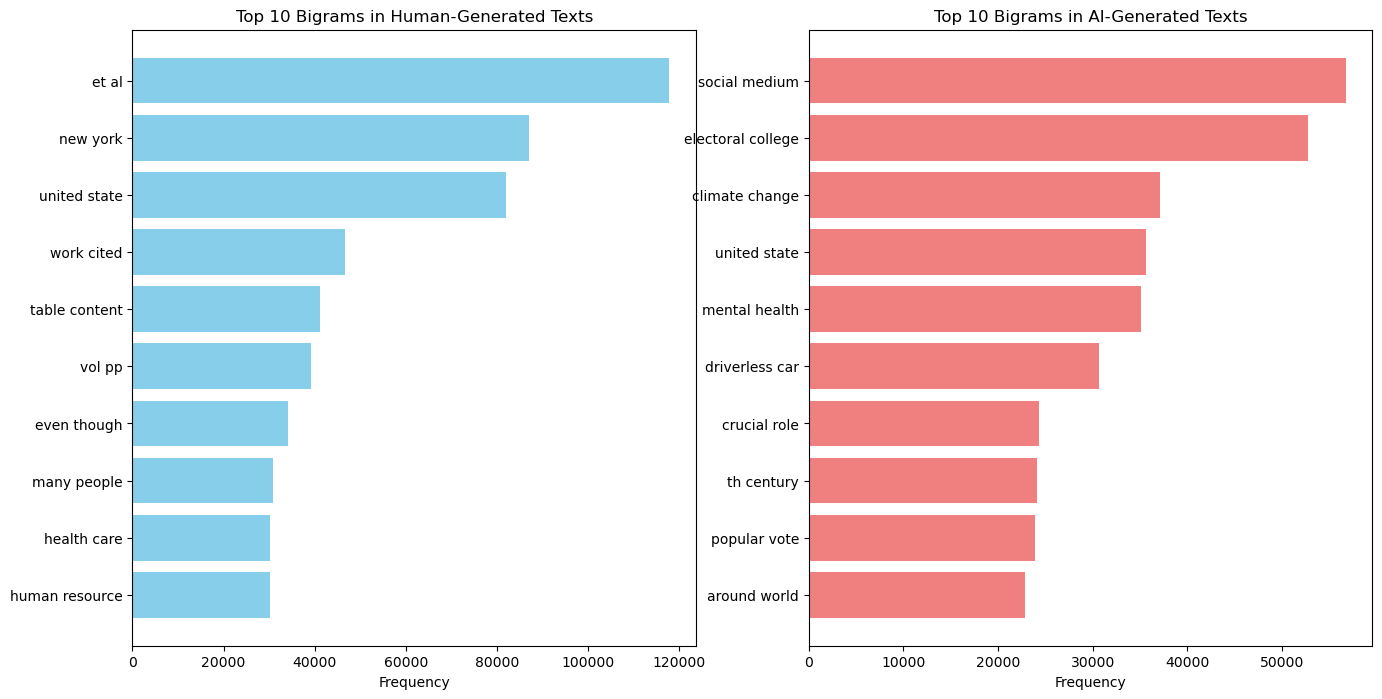

In [ ]:

human_bigrams_df = pd.DataFrame(human_commonb, columns=['Bigram', 'Frequency'])
ai_bigrams_df = pd.DataFrame(ai_commonb, columns=['Bigram', 'Frequency'])

# Plotting the bigrams
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.barh(human_bigrams_df['Bigram'].apply(' '.join), human_bigrams_df['Frequency'], color='skyblue')
plt.title('Top 10 Bigrams in Human-Generated Texts')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plt.subplot(1, 2, 2)
plt.barh(ai_bigrams_df['Bigram'].apply(' '.join), ai_bigrams_df['Frequency'], color='lightcoral')
plt.title('Top 10 Bigrams in AI-Generated Texts')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

plt.show()

In [ ]:
ai_texts = df[filtered_df['label'] == 1]['text']
# Check if "et al." is present in any AI-generated text
contains_et_al = ai_texts.str.contains('et al.', case=False, regex=False)

# esults
et_al_count = contains_et_al.sum()
print(f"'et al.' found in {et_al_count} AI-generated text(s) out of {len(ai_texts)}.")

'et al.' found in 2013 AI-generated text(s) out of 441227.


In [ ]:
ai_texts = filtered_df[filtered_df['label'] == 1]['text']

contains_work_cited = ai_texts.str.contains('work cited', case=False, regex=False)

# results
work_cited_count = contains_work_cited.sum()
print(f"'work cited' found in {work_cited_count} AI-generated text(s) out of {len(ai_texts)}.")

'work cited' found in 4 AI-generated text(s) out of 441227.


In [ ]:

contains_vol = ai_texts.str.contains('vol', case=False, regex=False)


contains_pp = ai_texts.str.contains('pp', case=False, regex=False)

# outputting results
vol_count = contains_vol.sum()
pp_count = contains_pp.sum()

print(f"'vol' found in {vol_count} AI-generated text(s) out of {len(ai_texts)}.")
print(f"'pp' found in {pp_count} AI-generated text(s) out of {len(ai_texts)}.")

'vol' found in 105139 AI-generated text(s) out of 441227.
'pp' found in 264089 AI-generated text(s) out of 441227.


##  Flesch-Kincaid

In [ ]:
import textstat

# Calculate Flesch-Kincaid
filtered_df['flesch_kincaid_score'] = filtered_df['text'].apply(textstat.flesch_kincaid_grade)

print(filtered_df[['text', 'flesch_kincaid_score']].head())

                                                text  flesch_kincaid_score
0  Federal law supersedes state law, and cannabis...                  10.8
1  Miles feels restless after working all day. He...                  10.3
2  So first of I am danish. That means that I fol...                   9.0
3  In this paper we present a novel rule-based ap...                  15.9
4  Most social progressives, love democracy, and ...                   9.1


In [ ]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

# Calculate lexical diversity
filtered_df['lexical_diversity'] = filtered_df['text'].apply(lexical_diversity)

print(filtered_df[['text', 'lexical_diversity']].head())

                                                text  lexical_diversity
0  Federal law supersedes state law, and cannabis...           0.904459
1  Miles feels restless after working all day. He...           0.798201
2  So first of I am danish. That means that I fol...           0.842697
3  In this paper we present a novel rule-based ap...           0.725236
4  Most social progressives, love democracy, and ...           0.850000


In [ ]:
# comparing FK scores between labels
flesch_kincaid_comparison = filtered_df.groupby('label')['flesch_kincaid_score'].agg(['mean', 'std'])
print("Flesch-Kincaid Readability Scores Comparison:")
print(flesch_kincaid_comparison)

# comparing LD between labels
lexical_diversity_comparison = filtered_df.groupby('label')['lexical_diversity'].agg(['mean', 'std'])
print("\nLexical Diversity Comparison:")
print(lexical_diversity_comparison)

Flesch-Kincaid Readability Scores Comparison:
            mean       std
label                     
0       9.706422  4.673530
1      10.476220  6.202768

Lexical Diversity Comparison:
           mean       std
label                    
0      0.581628  0.154090
1      0.648129  0.189807


In [ ]:
import numpy as np

# Flesch-Kincaid Readability Scores
mean_0_flesch = 9.706422
mean_1_flesch = 10.476220
std_0_flesch = 4.673530
std_1_flesch = 6.202768

# Lexical Diversity
mean_0_lexical = 0.581628
mean_1_lexical = 0.648129
std_0_lexical = 0.154090
std_1_lexical = 0.189807

# Cohen's d for FK
cohen_d_flesch = (mean_1_flesch - mean_0_flesch) / np.sqrt((std_0_flesch**2 + std_1_flesch**2) / 2)

# Cohen's d for LD
cohen_d_lexical = (mean_1_lexical - mean_0_lexical) / np.sqrt((std_0_lexical**2 + std_1_lexical**2) / 2)

cohen_d_flesch, cohen_d_lexical

(0.14017634803533652, 0.3846803483083732)

In [ ]:
import nltk
from collections import Counter

nltk.download('averaged_perceptron_tagger')

def pos_tag_distribution(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    pos_counts = Counter(tag for word, tag in pos_tags)
    total_count = sum(pos_counts.values())
    pos_distribution = {tag: count / total_count for tag, count in pos_counts.items()}
    return pos_distribution

# POS tagging and calculate distribution
filtered_df['pos_distribution'] = filtered_df['text'].apply(pos_tag_distribution)

# POS distribution for each text
print(filtered_df[['text', 'pos_distribution']].head())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\brotz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                                text  \
0  Federal law supersedes state law, and cannabis...   
1  Miles feels restless after working all day. He...   
2  So first of I am danish. That means that I fol...   
3  In this paper we present a novel rule-based ap...   
4  Most social progressives, love democracy, and ...   

                                    pos_distribution  
0  {'JJ': 0.08839779005524862, 'NN': 0.1215469613...  
1  {'NNS': 0.07034632034632035, 'VBP': 0.02164502...  
2  {'RB': 0.10443037974683544, 'JJ': 0.1044303797...  
3  {'IN': 0.1123152709359606, 'DT': 0.06108374384...  
4  {'JJS': 0.006864988558352402, 'JJ': 0.06636155...  


In [ ]:
# combine POS distributions for each label
def aggregate_pos_distribution(df, label):
    pos_distributions = df[df['label'] == label]['pos_distribution']
    aggregated_pos = Counter()

    for pos_dict in pos_distributions:
        aggregated_pos.update(pos_dict)

    # average distribution
    total_counts = sum(aggregated_pos.values())
    normalised_pos = {tag: count / total_counts for tag, count in aggregated_pos.items()}

    return normalised_pos

human_pos_distribution = aggregate_pos_distribution(filtered_df, 0)
ai_pos_distribution = aggregate_pos_distribution(filtered_df, 1)

comparison_df = pd.DataFrame([human_pos_distribution, ai_pos_distribution], index=['Human', 'AI']).fillna(0)

print(comparison_df.T)

             Human        AI
EX    1.937201e-03  0.001827
VBZ   2.555839e-02  0.025463
DT    9.137860e-02  0.086719
VBG   1.880405e-02  0.023547
IN    1.045665e-01  0.106560
PRP$  1.425317e-02  0.015269
NN    1.413202e-01  0.144361
,     4.057098e-02  0.041500
``    2.303602e-03  0.003111
PRP   4.002830e-02  0.040451
VBP   2.311516e-02  0.022091
JJ    7.136777e-02  0.077801
RB    4.066805e-02  0.040522
.     5.193706e-02  0.048095
''    2.235040e-03  0.003140
CC    3.152607e-02  0.034587
JJR   3.245841e-03  0.003335
NNS   5.855644e-02  0.065085
NNP   5.704966e-02  0.043885
VBN   2.013835e-02  0.020798
VBD   2.577625e-02  0.026579
TO    2.616105e-02  0.026405
VB    3.892432e-02  0.039495
:     4.221550e-03  0.003992
PDT   6.477911e-04  0.000376
WRB   4.589607e-03  0.004797
MD    1.373438e-02  0.013631
POS   1.974673e-03  0.003924
WDT   5.554303e-03  0.005704
CD    1.540896e-02  0.010442
NNPS  1.157840e-03  0.000768
(     5.083343e-03  0.002174
)     5.141446e-03  0.002279
RBR   1.618812

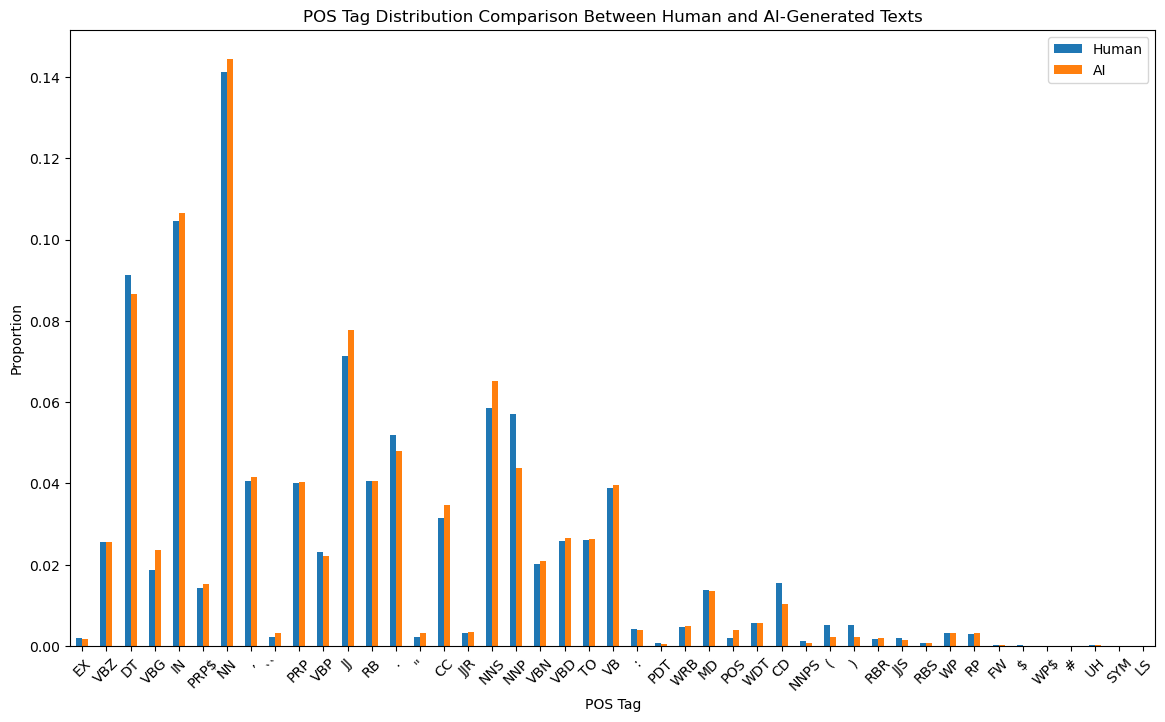

In [ ]:
import matplotlib.pyplot as plt

comparison_df.T.plot(kind='bar', figsize=(14, 8))
plt.title('POS Tag Distribution Comparison Between Human and AI-Generated Texts')
plt.xlabel('POS Tag')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

vader = SentimentIntensityAnalyzer()

# function to calculate VADER score
def vader_sentiment(text):
    return vader.polarity_scores(text)['compound']

# Apply VADER sentiment analysis to the text column
filtered_df['vader_sentiment'] = filtered_df['text'].apply(vader_sentiment)

print(filtered_df[['text', 'vader_sentiment']].head())

                                                text  vader_sentiment
0  Federal law supersedes state law, and cannabis...          -0.9618
1  Miles feels restless after working all day. He...           0.9995
2  So first of I am danish. That means that I fol...           0.9161
3  In this paper we present a novel rule-based ap...           0.9983
4  Most social progressives, love democracy, and ...           0.9888


In [ ]:
# TextBlob sentiment polarity
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply TextBlob
filtered_df['textblob_sentiment'] = filtered_df['text'].apply(textblob_sentiment)

print(filtered_df[['text', 'textblob_sentiment']].head())

                                                text  textblob_sentiment
0  Federal law supersedes state law, and cannabis...           -0.001556
1  Miles feels restless after working all day. He...            0.184772
2  So first of I am danish. That means that I fol...            0.036563
3  In this paper we present a novel rule-based ap...            0.071035
4  Most social progressives, love democracy, and ...            0.130294


In [ ]:
# both sentiment scores together
print(filtered_df[['text', 'vader_sentiment', 'textblob_sentiment']].head())

                                                text  vader_sentiment  \
0  Federal law supersedes state law, and cannabis...          -0.9618   
1  Miles feels restless after working all day. He...           0.9995   
2  So first of I am danish. That means that I fol...           0.9161   
3  In this paper we present a novel rule-based ap...           0.9983   
4  Most social progressives, love democracy, and ...           0.9888   

   textblob_sentiment  
0           -0.001556  
1            0.184772  
2            0.036563  
3            0.071035  
4            0.130294  


In [ ]:
# Compare VADER scores between labels
vader_comparison = filtered_df.groupby('label')['vader_sentiment'].agg(['mean', 'std'])
print("VADER Sentiment Scores Comparison:")
print(vader_comparison)

# Compare TextBlob scores between labels
textblob_comparison = filtered_df.groupby('label')['textblob_sentiment'].agg(['mean', 'std'])
print("\nTextBlob Sentiment Scores Comparison:")
print(textblob_comparison)

VADER Sentiment Scores Comparison:
           mean       std
label                    
0      0.469016  0.740288
1      0.525153  0.670591

TextBlob Sentiment Scores Comparison:
           mean       std
label                    
0      0.112752  0.121889
1      0.118913  0.140559


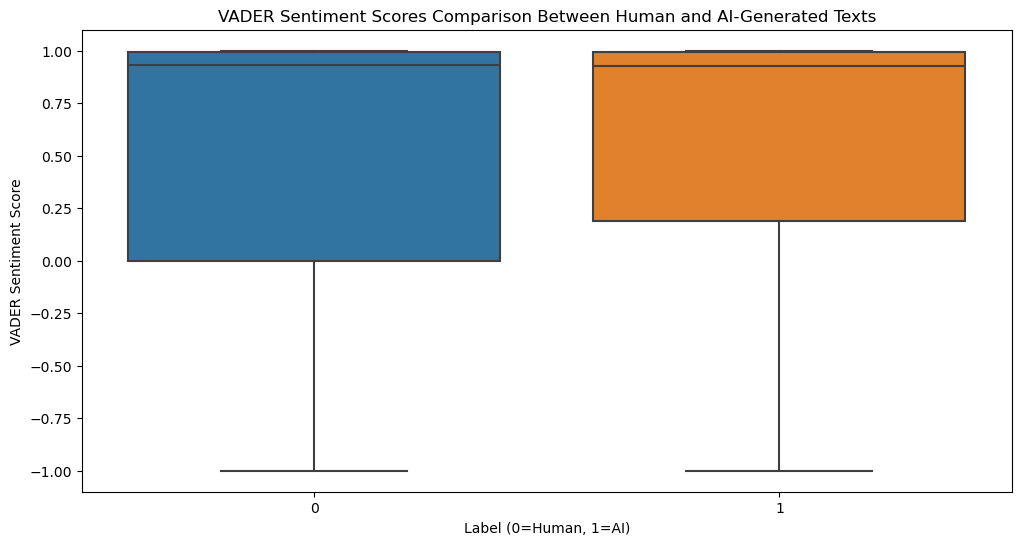

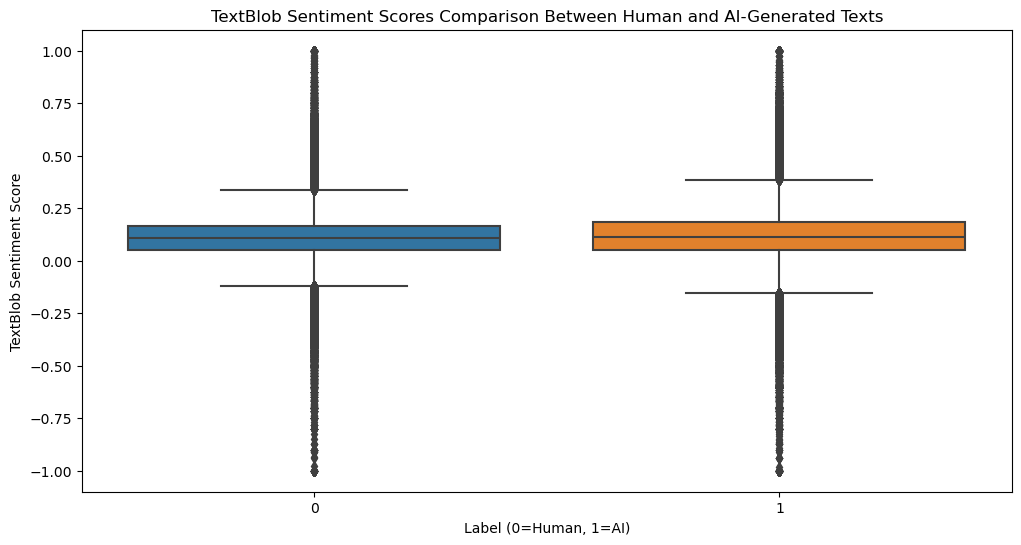

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='vader_sentiment', data=filtered_df)
plt.title('VADER Sentiment Scores Comparison Between Human and AI-Generated Texts')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('VADER Sentiment Score')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='textblob_sentiment', data=filtered_df)
plt.title('TextBlob Sentiment Scores Comparison Between Human and AI-Generated Texts')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('TextBlob Sentiment Score')
plt.show()

In [ ]:

numerical_features = ['text_length', 'vader_sentiment', 'textblob_sentiment', 'flesch_kincaid_score', 'lexical_diversity']


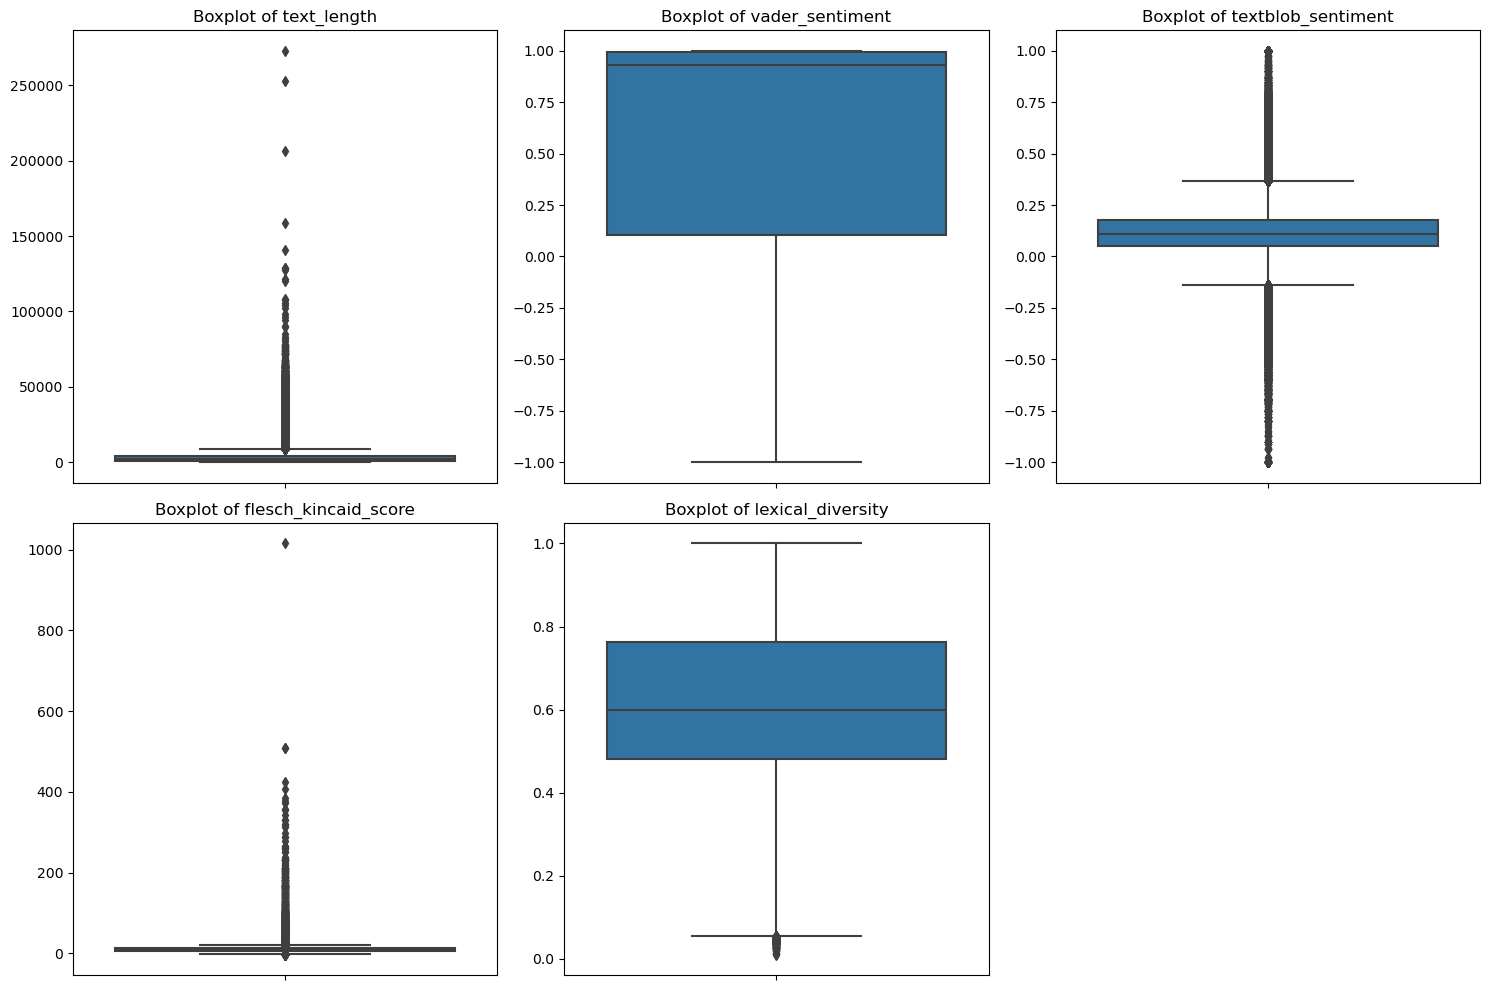

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create boxplots for each feature
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=filtered_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:

X = df['cleaned_text']
y = df['label']
# Tokenising the text and finding unique words
unique_words = set(word for sentence in X for word in sentence.split())

# unique words
num_unique_words = len(unique_words)

print(f"There are {num_unique_words} unique words in the dataset.")



There are 1090970 unique words in the dataset.


# 7. Testing classification using features:

In [ ]:
df_human = df[df['label'] == 0].copy()
df_ai = df[df['label'] == 1].copy()

In [ ]:
print("Number of human-labeled rows:", len(df_human))
print("Number of AI-labeled rows:", len(df_ai))

Number of human-labeled rows: 347692
Number of AI-labeled rows: 441230


In [ ]:
# reducing number of rows of each label to 340000

df0_sampled = df_human.sample(n=340000, random_state=42)
df1_sampled = df_ai.sample(n=340000, random_state=42)

# Concatenate the two sampled DataFrames
df_combined = pd.concat([df0_sampled, df1_sampled])

# Reset the index of the combined DataFrame
df_combined.reset_index(drop=True, inplace=True)

# nr of rows
print("Number of rows in the combined DataFrame:", len(df_combined))

Number of rows in the combined DataFrame: 680000


In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
from nltk.stem import PorterStemmer
from joblib import Parallel, delayed
import multiprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer

porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
# define which words are linking words
linking_words = {
    'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an',
    'but', 'or', 'nor', 'so', 'yet',
    'although', 'because', 'since', 'unless', 'until', 'while', 'whereas', 'if', 'even though', 'though', 'after', 'before', 'when', 'whenever',
    'about', 'above', 'across', 'against', 'along', 'among', 'around', 'before', 'behind', 'below', 'beneath', 'beside', 'between', 'beyond', 'by', 'despite', 'during', 'except', 'from', 'inside', 'into', 'near', 'off', 'over', 'past', 'through', 'toward', 'under', 'upon', 'within', 'without',
    'furthermore', 'moreover', 'besides', 'in addition', 'additionally',
    'however', 'nevertheless', 'on the other hand', 'yet', 'in contrast', 'instead',
    'therefore', 'consequently', 'thus', 'hence', 'as a result', 'accordingly',
    'first', 'next', 'then', 'finally', 'subsequently', 'afterward', 'meanwhile', 'eventually',
    'also', 'either', 'neither', 'both', 'each', 'every', 'another', 'such', 'one', 'no', 'not', 'only', 'rather', 'than', 'as', 'like', 'unlike', 'even', 'whether',
    'since', 'hence', 'indeed', 'meanwhile', 'therefore', 'likewise', 'similarly', 'in fact',
    'such as', 'for example', 'for instance', 'including', 'namely', 'like',
    'in conclusion', 'to conclude', 'to sum up', 'ultimately', 'in summary',
    'provided that', 'assuming that', 'as long as', 'in case', 'in the event that'
}

sid = SentimentIntensityAnalyzer()

num_cores = multiprocessing.cpu_count()

# Function to apply in parallel
def analyse_text_parallel(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in linking_words]
    tokens = [token for token in tokens if token.isalpha()]
    # Sentiment analysis
    sentiment_scores = sid.polarity_scores(text)
    return len(tokens), sentiment_scores['compound']

# Apply the function in parallel across the DataFrame
results = Parallel(n_jobs=num_cores)(delayed(analyse_text_parallel)(text) for text in df_combined['text'])

# Convert the results into a DataFrame
df_combined[['text_length', 'sentiment_score']] = pd.DataFrame(results, index=df_combined.index)



In [ ]:

import multiprocessing
import string
from nltk.tokenize import word_tokenize

def count_punctuation_marks(text):
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    return punctuation_count

def count_linking_words(text):
    linking_words_count = sum(1 for word in word_tokenize(text.lower()) if word in linking_words)
    return linking_words_count

# Apply the functions in parallel across the DataFrame
punctuation_counts = Parallel(n_jobs=num_cores)(delayed(count_punctuation_marks)(text) for text in df_combined['text'])
linking_words_counts = Parallel(n_jobs=num_cores)(delayed(count_linking_words)(text) for text in df_combined['text'])

# Assign the results back to the DataFrame
df_combined['punctuation_count'] = punctuation_counts
df_combined['linking_words_count'] = linking_words_counts


In [ ]:
df_combined['linking_words_count'] = df_combined['text'].apply(count_linking_words)

In [ ]:
df_combined.head()

,text,label,cleaned_text,text_length,sentiment_score,punctuation_count,linking_words_count
0,I was left to help my neighbor who was pregnan...,0,left help neighbor pregnant husband worked far...,131,0.9944,29,78
1,Slavery History: Letters Analysis Essay (Book ...,0,slavery history letter analysis essay book rev...,359,-0.9134,114,214
2,Volunteering is a part of my life that I have ...,0,volunteering part life cherished since small c...,103,0.9398,19,70
3,Project Risk Management in the 21st Century Re...,0,project risk management st century research pa...,1408,-0.9976,355,839
4,Sexual Harassment in the Workplace and Learnin...,0,sexual harassment workplace learning environme...,1222,-0.9998,454,684


In [ ]:
# filter by lable
df_human = df_combined[df_combined['label'] == 0]
df_ai = df_combined[df_combined['label'] == 1]

# calculate the mean values for label 0)
human_mean_punctuation = df_human['punctuation_count'].mean()
human_mean_linking_words = df_human['linking_words_count'].mean()
human_mean_text_length = df_human['text_length'].mean()
human_mean_sentiment_score = df_human['sentiment_score'].mean()

# mean values for label 1
ai_mean_punctuation = df_ai['punctuation_count'].mean()
ai_mean_linking_words = df_ai['linking_words_count'].mean()
ai_mean_text_length = df_ai['text_length'].mean()
ai_mean_sentiment_score = df_ai['sentiment_score'].mean()

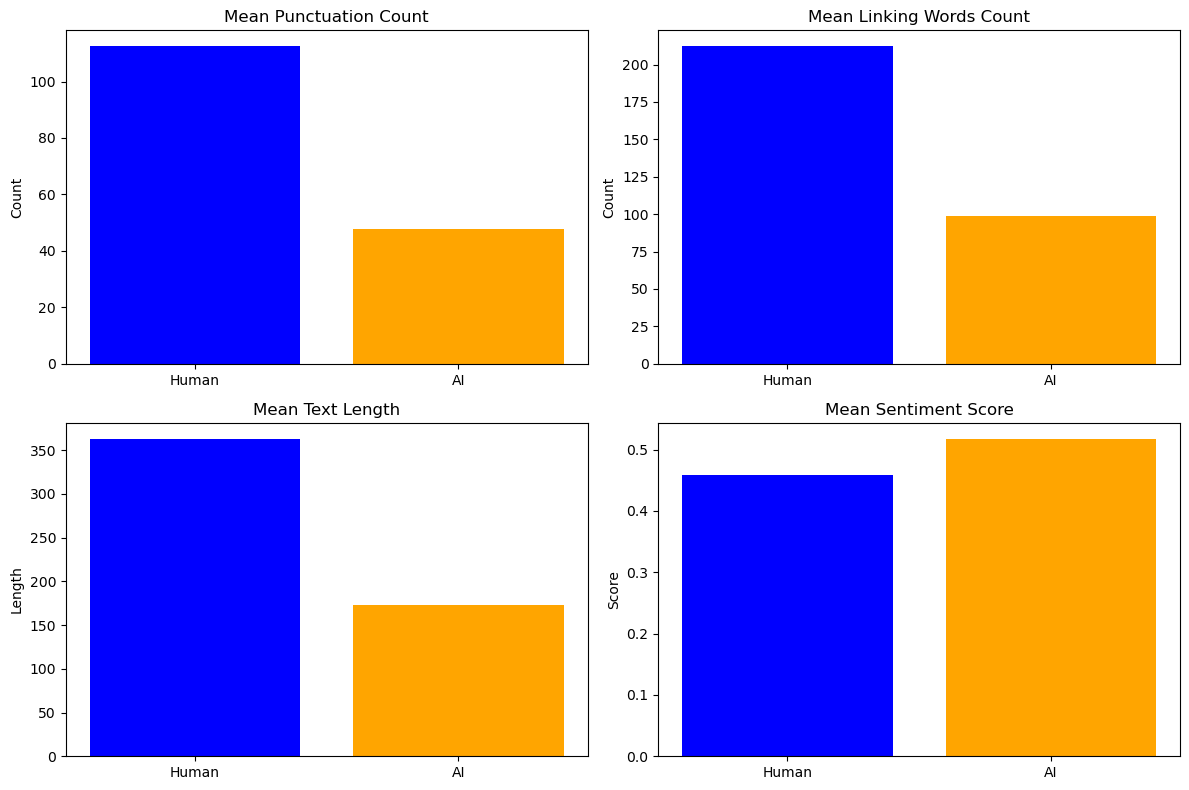

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Mean Punctuation Count
plt.subplot(2, 2, 1)
plt.bar(['Human', 'AI'], [human_mean_punctuation, ai_mean_punctuation], color=['blue', 'orange'])
plt.title('Mean Punctuation Count')
plt.ylabel('Count')

# Mean Linking Words Count
plt.subplot(2, 2, 2)
plt.bar(['Human', 'AI'], [human_mean_linking_words, ai_mean_linking_words], color=['blue', 'orange'])
plt.title('Mean Linking Words Count')
plt.ylabel('Count')

# Mean Text Length
plt.subplot(2, 2, 3)
plt.bar(['Human', 'AI'], [human_mean_text_length, ai_mean_text_length], color=['blue', 'orange'])
plt.title('Mean Text Length')
plt.ylabel('Length')

# Mean Sentiment Score
plt.subplot(2, 2, 4)
plt.bar(['Human', 'AI'], [human_mean_sentiment_score, ai_mean_sentiment_score], color=['blue', 'orange'])
plt.title('Mean Sentiment Score')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:


# duplicating of the DataFrame
df_combined_copy = df_combined.copy()

# Remove the columns text_length and sentiment_score as they are not going to be used in the model
df_combined_copy.drop(['text_length', 'sentiment_score'], axis=1, inplace=True)
print(df_combined_copy.head())
df_combined_copy.fillna(0, inplace=True)

# verify the changes
df_combined_copy



                                                text  label  \
0  I was left to help my neighbor who was pregnan...      0   
1  Slavery History: Letters Analysis Essay (Book ...      0   
2  Volunteering is a part of my life that I have ...      0   
3  Project Risk Management in the 21st Century Re...      0   
4  Sexual Harassment in the Workplace and Learnin...      0   

                                        cleaned_text  punctuation_count  \
0  left help neighbor pregnant husband worked far...                 29   
1  slavery history letter analysis essay book rev...                114   
2  volunteering part life cherished since small c...                 19   
3  project risk management st century research pa...                355   
4  sexual harassment workplace learning environme...                454   

   linking_words_count  
0                   78  
1                  214  
2                   70  
3                  839  
4                  684  


,text,label,cleaned_text,punctuation_count,linking_words_count
0,I was left to help my neighbor who was pregnan...,0,left help neighbor pregnant husband worked far...,29,78
1,Slavery History: Letters Analysis Essay (Book ...,0,slavery history letter analysis essay book rev...,114,214
2,Volunteering is a part of my life that I have ...,0,volunteering part life cherished since small c...,19,70
3,Project Risk Management in the 21st Century Re...,0,project risk management st century research pa...,355,839
4,Sexual Harassment in the Workplace and Learnin...,0,sexual harassment workplace learning environme...,454,684
...,...,...,...,...,...
679995,In this paper we study decomposition methods b...,1,paper study decomposition method based separab...,188,181
679996,The electoral college is a mechanism used in ...,1,electoral college mechanism used united state ...,40,170
679997,"In today’s competitive job market, employers a...",1,today competitive job market employer constant...,64,200
679998,"The 335ft (100m) Victorian structure, which cl...",1,ft victorian structure closed last year one uk...,27,50


In [ ]:
# tokenise text and remove stopwords
def tokenise_text(text, stop_words):
    tokens = word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha() and token not in stop_words]

# Parallelise tokenization and word counting
all_words = Parallel(n_jobs=num_cores)(
    delayed(tokenise_text)(text, stop_words) for text in df_combined_copy['text']
)
all_words_flat = [word for sublist in all_words for word in sublist]
word_counts = Counter(all_words_flat)

# Select the top 500 most common words as features
top_words = [word for word, _ in word_counts.most_common(500)]

# Function to create binary features for the top words
def create_word_features(text, top_words, stop_words):
    tokens = tokenise_text(text, stop_words)
    return [1 if word in tokens else 0 for word in top_words]

# Function to calculate text length
def lengthText(text):
    tokens = word_tokenize(text.lower())
    return len(tokens)

# Apply the functions in parallel
df_combined_copy['length_text'] = Parallel(n_jobs=num_cores)(
    delayed(lengthText)(text) for text in df_combined_copy['text']
)
df_combined_copy['word_features'] = Parallel(n_jobs=num_cores)(
    delayed(create_word_features)(text, top_words, stop_words) for text in df_combined_copy['text']
)

df_combined_copy




,text,label,cleaned_text,punctuation_count,linking_words_count,length_text,word_features
0,I was left to help my neighbor who was pregnan...,0,left help neighbor pregnant husband worked far...,29,78,316,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
1,Slavery History: Letters Analysis Essay (Book ...,0,slavery history letter analysis essay book rev...,114,214,834,"[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, ..."
2,Volunteering is a part of my life that I have ...,0,volunteering part life cherished since small c...,19,70,271,"[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, ..."
3,Project Risk Management in the 21st Century Re...,0,project risk management st century research pa...,355,839,2901,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, ..."
4,Sexual Harassment in the Workplace and Learnin...,0,sexual harassment workplace learning environme...,454,684,2718,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, ..."
...,...,...,...,...,...,...,...
679995,In this paper we study decomposition methods b...,1,paper study decomposition method based separab...,188,181,962,"[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ..."
679996,The electoral college is a mechanism used in ...,1,electoral college mechanism used united state ...,40,170,514,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
679997,"In today’s competitive job market, employers a...",1,today competitive job market employer constant...,64,200,630,"[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, ..."
679998,"The 335ft (100m) Victorian structure, which cl...",1,ft victorian structure closed last year one uk...,27,50,206,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:


# calculate punctuation count percentage
def calculate_p_count(text):
    return count_punctuation_marks(text) / len(word_tokenize(text)) * 100

# calculate linking words count percentage
def calculate_lw_count(text):
    return count_linking_words(text) / len(word_tokenize(text)) * 100

punctuation_percentages = Parallel(n_jobs=num_cores)(
    delayed(calculate_p_count)(text) for text in df_combined_copy['text']
)

linking_words_percentages = Parallel(n_jobs=num_cores)(
    delayed(calculate_lw_count)(text) for text in df_combined_copy['text']
)
df_combined_copy['punctuation_count_percentage'] = punctuation_percentages
df_combined_copy['linking_words_percentage'] = linking_words_percentages




In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned_text column
tfidf_features = tfidf.fit_transform(df_combined_copy['cleaned_text'])

# Convert the TF-IDF features into a DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

# Combine TF-IDF features with the other features
X = pd.DataFrame(df_combined_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_combined_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_combined_copy['linking_words_percentage']


X = pd.concat([X.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Target variable
y = df_combined_copy['label']

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8003725490196079
Train Loss: 0.3836693661564694
Test Loss: 0.38597296336046977
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80    101927
           1       0.79      0.83      0.81    102073

    accuracy                           0.80    204000
   macro avg       0.80      0.80      0.80    204000
weighted avg       0.80      0.80      0.80    204000

Class-wise Metrics:
              precision    recall  f1-score        support
0              0.816134  0.775074  0.795075  101927.000000
1              0.786140  0.825635  0.805403  102073.000000
accuracy       0.800373  0.800373  0.800373       0.800373
macro avg      0.801137  0.800354  0.800239  204000.000000
weighted avg   0.801127  0.800373  0.800243  204000.000000


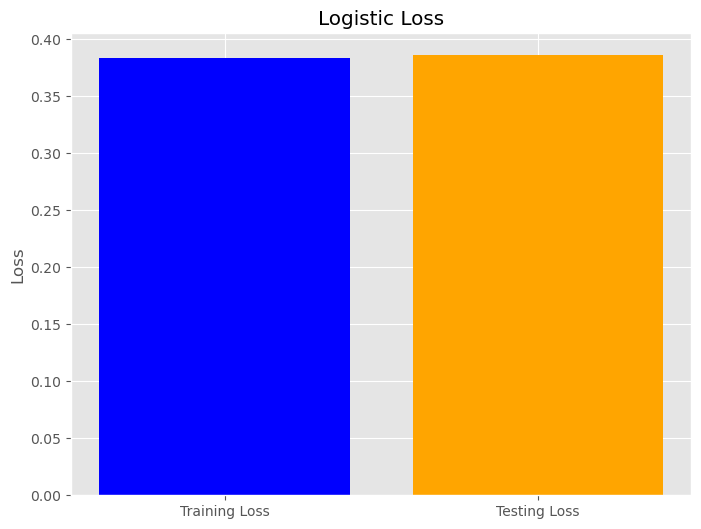

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_imputed, y_train)


y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

train_loss = log_loss(y_train, model.predict_proba(X_train_imputed))
test_loss = log_loss(y_test, model.predict_proba(X_test_imputed))
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

loss_values = [train_loss, test_loss]
labels = ['Training Loss', 'Testing Loss']

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Logistic Loss')
plt.ylabel('Loss')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - accuracy: 0.7801 - loss: 0.4087 - val_accuracy: 0.8272 - val_loss: 0.3393
Epoch 2/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 119s 8ms/step - accuracy: 0.8201 - loss: 0.3480 - val_accuracy: 0.8337 - val_loss: 0.3273
Epoch 3/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 126s 8ms/step - accuracy: 0.8284 - loss: 0.3342 - val_accuracy: 0.8343 - val_loss: 0.3244
Epoch 4/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 116s 8ms/step - accuracy: 0.8344 - loss: 0.3244 - val_accuracy: 0.8383 - val_loss: 0.3194
Epoch 5/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - accuracy: 0.8376 - loss: 0.3183 - val_accuracy: 0.8430 - val_loss: 0.3141
Epoch 6/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 114s 8ms/step - accuracy: 0.8416 - loss: 0.3137 - val_accuracy: 0.8420 - val_loss: 0.3139
Epoch 7/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 112s 8ms/step - accuracy: 0.8433 - loss: 0.3084 - val_accuracy: 0.8422 - val_loss: 0.3177
Epoch 8/10
14875/14875 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - ac

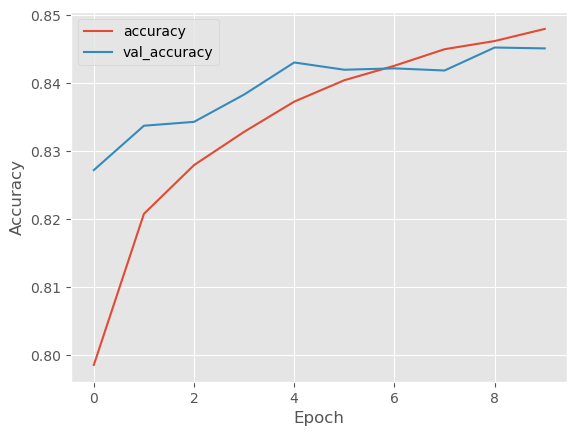

In [ ]:
# Define features
X = pd.DataFrame(df_combined_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_combined_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_combined_copy['linking_words_percentage']

y = df_combined_copy['label']

# Split the data into training and testing sets
X_train, X_validationid, y_train, y_validationid = train_test_split(X, y, test_size=0.3, random_state=42)

# initialise SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)

X_train_imputed = imputer.fit_transform(X_train)
X_validationid_imputed = imputer.transform(X_validationid)

X_train_cnn = X_train_imputed.reshape(X_train_imputed.shape[0], X_train_imputed.shape[1], 1)
X_validationid_cnn = X_validationid_imputed.reshape(X_validationid_imputed.shape[0], X_validationid_imputed.shape[1], 1)

# Define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_validationid_cnn, y_validationid))

# Evaluate model
y_train_pred_probs = model.predict(X_train_cnn)
y_validationid_pred_probs = model.predict(X_validationid_cnn)

# Convert probabilities to class predictions
y_train_pred = (y_train_pred_probs > 0.5).astype(int)
y_validationid_pred = (y_validationid_pred_probs > 0.5).astype(int)

# Calculate train error
train_error = 1 - accuracy_score(y_train, y_train_pred)

# Calculate validation error
validation_error = 1 - accuracy_score(y_validationid, y_validationid_pred)

print("Train Error:", train_error)
print("Validation Error:", validation_error)

# Plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8. Testing classification using preprocessed text:

## EVALUATE MODEL function

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate models
def evaluate_model(model):
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")

## Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Creating a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = pipeline.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8432477310753942
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82     69778
           1       0.84      0.89      0.86     88006

    accuracy                           0.84    157784
   macro avg       0.84      0.84      0.84    157784
weighted avg       0.84      0.84      0.84    157784



## Testing Size Reduction

In [ ]:
X = df['cleaned_text']
y = df['label']

X_sample = X.sample(frac=0.2, random_state=42)
y_sample = y.sample(frac=0.2, random_state=42)

# Feature sizes to test
feature_sizes = [5000, 7000, 10000]

# Results dictionary
results = {'Features': [], 'Original TF-IDF Accuracy': [], 'Truncated SVD Accuracy': [], 'PCA Accuracy': []}


def evaluate_pipeline(tfidf_max_features, method='original'):
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=tfidf_max_features, max_df=0.85, min_df=5)

    # Create the pipeline
    if method == 'svd':
        svd = TruncatedSVD(n_components=500)
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('svd', svd),
            ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
        ])
    elif method == 'pca':
        pca = PCA(n_components=500)
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('pca', pca),
            ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
        ])
    else:
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
        ])


    scores = cross_val_score(pipeline, X_sample, y_sample, cv=5, scoring='accuracy', n_jobs=-1)

    return scores.mean()


for size in feature_sizes:
    # Evaluate with original TF-IDF
    tfidf_acc = evaluate_pipeline(size, method='original')

    # Evaluate with Truncated SVD
    svd_acc = evaluate_pipeline(size, method='svd')

    # Evaluate with PCA
    pca_acc = evaluate_pipeline(size, method='pca')

    # Store results
    results['Features'].append(size)
    results['Original TF-IDF Accuracy'].append(tfidf_acc)
    results['Truncated SVD Accuracy'].append(svd_acc)
    results['PCA Accuracy'].append(pca_acc)


In [ ]:

results_df = pd.DataFrame(results)

# Display the results
print(results_df)

   Features  Original TF-IDF Accuracy  Truncated SVD Accuracy  PCA Accuracy
0      5000                  0.833494                0.793623      0.794529
1      7000                  0.838006                0.795930      0.795949
2     10000                  0.842557                0.795689      0.795892


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import joblib
import numpy as np


X = df['cleaned_text']
y = df['label']

# initialise TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, max_df=0.85, min_df=2)

# Transform the text data using TfidfVectorizer
X_tfidf = tfidf.fit_transform(X)

# initialise TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=500)

# Fit TruncatedSVD on the TF-IDF transformed data
X_svd = svd.fit_transform(X_tfidf)

# Save the transformed array to a .npy file
np.save('X_svd.npy', X_svd)

Transformed data has been saved as 'X_svd.npy'


In [ ]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y = df['label']

# Define the Logistic Regression model
clf = LogisticRegression(solver='liblinear', max_iter=1000)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', needs_proba=True)
}

# Perform cross-validation with multiple metrics
scores = cross_validate(clf, X_svd, y, cv=5, scoring=scoring, return_train_score=False)

# Printresults
print("Cross-validation metrics:")
print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
print(f"Precision: {scores['test_precision'].mean():.4f}")
print(f"Recall: {scores['test_recall'].mean():.4f}")
print(f"F1 Score: {scores['test_f1'].mean():.4f}")
print(f"ROC AUC: {scores['test_roc_auc'].mean():.4f}")




C:\Users\brotz\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-validation metrics:
Accuracy: 0.7564
Precision: 0.7575
Recall: 0.7564
F1 Score: 0.7525
ROC AUC: 0.8354


## Random Forest

In [ ]:
text_lengths = [len(tokenizer(text, truncation=False)['input_ids']) for text in df['cleaned_text']]
print(f"Average length: {np.mean(text_lengths)}")
print(f"Median length: {np.median(text_lengths)}")
print(f"Max length: {np.max(text_lengths)}")

Average length: 349.83655239971915
Median length: 207.0
Max length: 51368


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Results:")# Random Forest
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     75379
           1       0.86      0.94      0.90     95473

    accuracy                           0.88    170852
   macro avg       0.88      0.87      0.88    170852
weighted avg       0.88      0.88      0.88    170852

[[60861 14518]
 [ 6079 89394]]
Accuracy: 0.8794453679207735


##  Gradient Boosting

In [ ]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# evaluate
print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70     75379
           1       0.74      0.94      0.83     95473

    accuracy                           0.78    170852
   macro avg       0.81      0.76      0.76    170852
weighted avg       0.80      0.78      0.77    170852

[[43742 31637]
 [ 5866 89607]]
Accuracy: 0.7804942289232786


##  MultinomialNB

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# train the NBayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate
print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     75379
           1       0.76      0.80      0.78     95473

    accuracy                           0.75    170852
   macro avg       0.74      0.74      0.74    170852
weighted avg       0.75      0.75      0.75    170852

[[50887 24492]
 [18758 76715]]
Accuracy: 0.746856928803877


##  KNeighbors

In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier

# Define and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate
print("k-NN Results:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")

k-NN Results:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79     75379
           1       0.89      0.72      0.79     95473

    accuracy                           0.79    170852
   macro avg       0.80      0.80      0.79    170852
weighted avg       0.81      0.79      0.79    170852

[[67064  8315]
 [27029 68444]]
Accuracy: 0.7931308969166296


## Xgboost

In [ ]:
import xgboost as xgb

# train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")

XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     69778
           1       0.78      0.95      0.86     88006

    accuracy                           0.82    157784
   macro avg       0.85      0.80      0.81    157784
weighted avg       0.84      0.82      0.81    157784

[[45641 24137]
 [ 4173 83833]]
Accuracy: 0.8205774983521776


## MLP Classifier

In [ ]:

from sklearn.neural_network import MLPClassifier

#  train the Neural Network model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate
print("Neural Network Results:")
print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")

Neural Network Results:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     69778
           1       0.92      0.94      0.93     88006

    accuracy                           0.92    157784
   macro avg       0.92      0.92      0.92    157784
weighted avg       0.92      0.92      0.92    157784

[[62530  7248]
 [ 5695 82311]]
Accuracy: 0.9179701363889875


## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Define and train the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_model.predict(X_test)

# Evaluate the model
print("AdaBoost Results:")
print(classification_report(y_test, y_pred_ada))
print(confusion_matrix(y_test, y_pred_ada))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada)}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Results:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74     69778
           1       0.77      0.88      0.82     88006

    accuracy                           0.79    157784
   macro avg       0.79      0.78      0.78    157784
weighted avg       0.79      0.79      0.79    157784

[[47130 22648]
 [10643 77363]]
Accuracy: 0.7890090249961973


## Linear Discriminant analysis

In [ ]:
from sklearn.model_selection import train_test_split

# Subsample the data
#X_train_small, _, y_train_small, _ = train_test_split(X_train1, y_train1, train_size=0.3, random_state=42, stratify=y_train1)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
evaluate_model(lda)

Confusion Matrix:
 [[27238  7882]
 [ 7008 28514]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     35120
           1       0.78      0.80      0.79     35522

    accuracy                           0.79     70642
   macro avg       0.79      0.79      0.79     70642
weighted avg       0.79      0.79      0.79     70642

Accuracy: 0.7892
Precision: 0.7834
Recall: 0.8027
F1-Score: 0.7930
AUC-ROC: 0.7891


## qda

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
evaluate_model(qda)

Confusion Matrix:
 [[26311  8809]
 [ 7171 28351]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77     35120
           1       0.76      0.80      0.78     35522

    accuracy                           0.77     70642
   macro avg       0.77      0.77      0.77     70642
weighted avg       0.77      0.77      0.77     70642

Accuracy: 0.7738
Precision: 0.7629
Recall: 0.7981
F1-Score: 0.7801
AUC-ROC: 0.7736


## perceptron

In [ ]:
from sklearn.linear_model import Perceptron

#test different params
params = {'penalty': [None, 'l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01]}
perceptron = GridSearchCV(Perceptron(max_iter=1000), params, cv=5)
perceptron.fit(X_train, y_train)
evaluate_model(perceptron)

Confusion Matrix:
 [[19983 15137]
 [ 3565 31957]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.57      0.68     35120
           1       0.68      0.90      0.77     35522

    accuracy                           0.74     70642
   macro avg       0.76      0.73      0.73     70642
weighted avg       0.76      0.74      0.73     70642

Accuracy: 0.7353
Precision: 0.6786
Recall: 0.8996
F1-Score: 0.7736
AUC-ROC: 0.7343


## Balanced RandomForest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
#est hyperparameters

params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
balanced_rf = GridSearchCV(BalancedRandomForestClassifier(), params, cv=5)
balanced_rf.fit(X_train, y_train)


In [ ]:
evaluate_model(balanced_rf)

Confusion Matrix:
 [[29969  5151]
 [ 3734 31788]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87     35120
           1       0.86      0.89      0.88     35522

    accuracy                           0.87     70642
   macro avg       0.87      0.87      0.87     70642
weighted avg       0.87      0.87      0.87     70642

Accuracy: 0.8742
Precision: 0.8606
Recall: 0.8949
F1-Score: 0.8774
AUC-ROC: 0.8741


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline

smote_pipeline = Pipeline([
    ('smote', SMOTE()),  # SMOTE step
    ('lr', LogisticRegression())  # Logistic Regression step
])

# train model
smote_pipeline.fit(X_train, y_train)

# evaluate the model
evaluate_model(smote_pipeline)

Confusion Matrix:
 [[28683  6437]
 [ 5653 29869]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     35120
           1       0.82      0.84      0.83     35522

    accuracy                           0.83     70642
   macro avg       0.83      0.83      0.83     70642
weighted avg       0.83      0.83      0.83     70642

Accuracy: 0.8289
Precision: 0.8227
Recall: 0.8409
F1-Score: 0.8317
AUC-ROC: 0.8288


##  Blended Model

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict_proba(X_test)[:, 1]
gb_pred = gb_model.predict_proba(X_test)[:, 1]

# Average the predictions
blended_pred = (rf_pred + gb_pred) / 2
blended_pred = np.round(blended_pred)

# Evaluate
print(f"Blended Model Accuracy: {accuracy_score(y_test, blended_pred):.4f}")

Blended Model Accuracy: 0.8416


## Bagging Model

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the base model
base_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Create a bagging classifier using the base model
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

# Evaluate
print(f"Bagging Model Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")

Bagging Model Accuracy: 0.7040


## lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20]
}

lgbm = GridSearchCV(lgb.LGBMClassifier(), params, cv=5, scoring='roc_auc')
lgbm.fit(X_train, y_train)
evaluate_model(lgbm)

[LightGBM] [Info] Number of positive: 112865, number of negative: 113187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.799428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017565
[LightGBM] [Info] Number of data points in the train set: 226052, number of used features: 4000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499288 -> initscore=-0.002849
[LightGBM] [Info] Start training from score -0.002849
[LightGBM] [Info] Number of positive: 112866, number of negative: 113187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.724445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017627
[LightGBM] [Info] Number of data points in the train set: 226053, number of used features: 4000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499290 -> initscore=-0.002840
[LightGBM] [Info] Start training from score -0.002

## Catboost

In [ ]:
from catboost import CatBoostClassifier

params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 10]
}

catboost = GridSearchCV(CatBoostClassifier(verbose=0), params, cv=5, scoring='roc_auc')
catboost.fit(X_train, y_train)
evaluate_model(catboost)

Confusion Matrix:
 [[27448  7672]
 [ 3639 31883]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     35120
           1       0.81      0.90      0.85     35522

    accuracy                           0.84     70642
   macro avg       0.84      0.84      0.84     70642
weighted avg       0.84      0.84      0.84     70642

Accuracy: 0.8399
Precision: 0.8060
Recall: 0.8976
F1-Score: 0.8493
AUC-ROC: 0.8396


## WORD2VEC model

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model on the preprocessed text data using CPU
word2vec_model = Word2Vec(sentences=processed_texts, vector_size=500, window=5, min_count=1, workers=4)

# Save the model if needed
word2vec_model.save("word2vec.model")


In [ ]:
import numpy as np

def text_to_vector(text, model):
    vector = np.mean([model.wv[word] for word in text if word in model.wv], axis=0)
    return vector if vector is not None else np.zeros(model.vector_size)

# Convert all texts to vectors
X = np.array([text_to_vector(text, word2vec_model) for text in processed_texts])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


labels = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.7918
Precision: 0.7921
Recall: 0.7918
F1 Score: 0.7918
Confusion Matrix:
[[28264  6856]
 [ 7850 27672]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     35120
           1       0.80      0.78      0.79     35522

    accuracy                           0.79     70642
   macro avg       0.79      0.79      0.79     70642
weighted avg       0.79      0.79      0.79     70642



## Word embeddings

In [ ]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('./dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
import numpy as np

# initialise an empty dictionary to store the GloVe embeddings
glove_embeddings = {}

# Path tGloVe file
glove_file_path = './dataset/glove.840B.300d.txt'

with open(glove_file_path, "r", encoding="utf8") as f:
    # Iterate over each line in the file
    for line in f:
        # Split the line into words and vectors
        values = line.split()
        word = values[0]
        try:
            # Convert the remaining values into a numpy array of floats
            vector = np.asarray(values[1:], dtype="float32")
            # Add the word and its vector to the dictionary
            glove_embeddings[word] = vector
        except ValueError as e:
            print(f"Skipping line due to error: {e}")
            print(f"Problematic line: {line}")
            continue


In [ ]:
from gensim.models import FastText

fasttext_model = FastText.load_fasttext_format('./dataset/cc.en.300.bin')

C:\Users\brotz\AppData\Local\Temp\ipykernel_129784\1868560175.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format(r'C:\Users\brotz\Downloads\dataset\cc.en.300.bin')


In [ ]:
from gensim.models import FastText

# Load the pre-trained FastText vectors
fasttext_model = FastText.load_facebook_vectors('./dataset/cc.en.300.bin')


In [ ]:
from gensim.models import KeyedVectors

# Load the GloVe model directly using Gensim
glove_file_path = 'C:/Users/brotz/Downloads/dataset/glove.840B.300d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False, no_header=True)



In [ ]:
import numpy as np
import pandas as pd

# Function to compute Word2Vec embeddings
def get_word2vec_embedding(text):
    vectors = [word2vec_model[word] for word in text if word in word2vec_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Function to compute GloVe embeddings
def get_glove_embedding(text):
    vectors = [glove_model[word] for word in text if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

def get_fasttext_embedding(text):
    vectors = [fasttext_model.get_vector(word) for word in text if word in fasttext_model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)  #


In [ ]:
# Applying the functions to the 'cleaned_text' column in the DataFrame
df['word2vec_embedding'] = df['cleaned_text'].apply(get_word2vec_embedding)

# Check the result
print(df.head())

In [ ]:
df['glove_embedding'] = df['cleaned_text'].apply(get_glove_embedding)



In [ ]:
def get_fasttext_embedding(text):
    vectors = [fasttext_model.wv.get_vector(word) for word in text if word in fasttext_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(fasttext_model.wv.vector_size)



In [ ]:
df['fasttext_embedding'] = df['cleaned_text'].apply(get_fasttext_embedding)


In [ ]:
import numpy as np
import pandas as pd

# Function to compute Word2Vec embeddings
def get_word2vec_embedding(text):
    vectors = [word2vec_model[word] for word in text if word in word2vec_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Return

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


X_word2vec = np.stack(df['word2vec_embedding'].values)
X_glove = np.stack(df['glove_embedding'].values)
X_fasttext = np.stack(df['fasttext_embedding'].values)
y = df['label'].values

# Split the data into training and test sets
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, _, _ = train_test_split(X_glove, y, test_size=0.2, random_state=42)
X_train_fasttext, X_test_fasttext, _, _ = train_test_split(X_fasttext, y, test_size=0.2, random_state=42)

# initialise the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Function to train and evaluate the model
def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_pred_prob = logreg.predict_proba(X_test)[:, 1]

    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

# Evaluate on each embedding type
evaluate_model(X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec Embedding")
evaluate_model(X_train_glove, X_test_glove, y_train, y_test, "GloVe Embedding")
evaluate_model(X_train_fasttext, X_test_fasttext, y_train, y_test, "FastText Embedding")

--- Word2Vec Embedding ---
Accuracy: 0.5518460421885608
ROC-AUC: 0.5908561082637679
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.14      0.22     75379
           1       0.56      0.87      0.69     95473

    accuracy                           0.55    170852
   macro avg       0.52      0.51      0.45    170852
weighted avg       0.52      0.55      0.48    170852



--- GloVe Embedding ---
Accuracy: 0.5551998220682228
ROC-AUC: 0.5933668269638811
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.17      0.26     75379
           1       0.57      0.86      0.68     95473

    accuracy                           0.56    170852
   macro avg       0.53      0.51      0.47    170852
weighted avg       0.53      0.56      0.49    170852



--- FastText Embedding ---
Accuracy: 0.5566045466251492
ROC-AUC: 0.6028148477020289
Classification Report:
               precisi

# Neural Network Sequential Models

### Sequential Model 1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix



# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# simple neural network model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=y_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print(classification_report(y_test_classes, y_pred_classes))
print(confusion_matrix(y_test_classes, y_pred_classes))

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8050 - loss: 0.3846 - val_accuracy: 0.8723 - val_loss: 0.2697
Epoch 2/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8875 - loss: 0.2478 - val_accuracy: 0.8814 - val_loss: 0.2511
Epoch 3/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9130 - loss: 0.2012 - val_accuracy: 0.8844 - val_loss: 0.2514
Epoch 4/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9290 - loss: 0.1698 - val_accuracy: 0.8906 - val_loss: 0.2446
Epoch 5/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9401 - loss: 0.1453 - val_accuracy: 0.8928 - val_loss: 0.2516
Epoch 6/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9483 - loss: 0.1287 - val_accuracy: 0.8936 - val_loss: 0.2576
Epoch 7/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9550 - loss: 0.1126 - val_accuracy: 0.8940 - val_loss: 0.2637
Epoch 8/10
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9588 - loss: 0.1026 -

### Sequential Model 2

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix



# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# simple neural network model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=y_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_split=0.2)

# Find the best performing epoch
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch + 1}")

# Print out all metrics for the best performing epoch
best_metrics = {
    "val_loss": history.history['val_loss'][best_epoch],
    "val_accuracy": history.history['val_accuracy'][best_epoch],
    "train_loss": history.history['loss'][best_epoch],
    "train_accuracy": history.history['accuracy'][best_epoch]
}

print(f"Metrics for Best Epoch {best_epoch + 1}:")
for key, value in best_metrics.items():
    print(f"{key}: {value}")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print(classification_report(y_test_classes, y_pred_classes))
print(confusion_matrix(y_test_classes, y_pred_classes))

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8051 - loss: 0.3844 - val_accuracy: 0.8695 - val_loss: 0.2707
Epoch 2/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8880 - loss: 0.2465 - val_accuracy: 0.8829 - val_loss: 0.2502
Epoch 3/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9148 - loss: 0.1992 - val_accuracy: 0.8874 - val_loss: 0.2439
Epoch 4/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9296 - loss: 0.1686 - val_accuracy: 0.8893 - val_loss: 0.2485
Epoch 5/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9391 - loss: 0.1465 - val_accuracy: 0.8930 - val_loss: 0.2502
Epoch 6/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9483 - loss: 0.1280 - val_accuracy: 0.8939 - val_loss: 0.2533
Epoch 7/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9551 - loss: 0.1128 - val_accuracy: 0.8933 - val_loss: 0.2735
Epoch 8/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9598 -

### Sequential Model Find Best HyperParameters (SM Model 3)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from kerastuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping


tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])
y_encoded = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

def build_model(hp):
    model = Sequential()


    model.add(Dense(units=hp.Int('units', min_value=64, maX_validationue=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, maX_validationue=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, maX_validationue=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, maX_validationue=0.5, step=0.1)))

    model.add(Dense(units=y_encoded.shape[1], activation='softmax'))


    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=2,
    directory='my_dir',
    project_name='tfidf_text_classification'
)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2,
             callbacks=[early_stopping])


best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))
print(confusion_matrix(y_test_classes, y_pred_classes))

Trial 44 Complete [00h 03m 32s]
val_accuracy: 0.9070230424404144

Best val_accuracy So Far: 0.9075981080532074
Total elapsed time: 02h 55m 58s

Search: Running Trial #45

Value             |Best Value So Far |Hyperparameter
320               |512               |units
0.5               |0.4               |dropout
3                 |3                 |num_layers
224               |96                |units_0
0.2               |0.2               |dropout_0
0.001             |0.001             |learning_rate
512               |352               |units_1
0.1               |0.1               |dropout_1
448               |512               |units_2
0.5               |0.2               |dropout_2

Epoch 1/30
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8188 - loss: 0.3595 - val_accuracy: 0.8815 - val_loss: 0.2596
Epoch 2/30
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9031 - loss: 0.2216 - val_accuracy: 0.8906 - val_loss: 0.2474
Epoch 3/30
7065/7065 ━━━━━━━━━━━━━━━━━━━

### Sequential Model 4

In [ ]:
def create_model(learning_rate=0.001, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_dim=X1_svd.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

# Hyperparameters to try
learning_rate = 0.001
dropout_rate = 0.3
activation = 'relu'
units_layer1 = 128
units_layer2 = 64
batch_size = 32
epochs = 1000

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1_svd, y1, test_size=0.2, random_state=42, stratify=y1)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Callback to track metrics at each epoch
class EpochPerformance(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_performance['epoch'].append(epoch)
        epoch_performance['val_loss'].append(logs['val_loss'])
        epoch_performance['accuracy'].append(logs['accuracy'])
        epoch_performance['val_accuracy'].append(logs['val_accuracy'])
        tqdm_bar.update(1)  # Update the progress bar for each epoch

# Dictionary to store the performance metrics at each epoch
epoch_performance = {
    'epoch': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Create the model
model = Sequential()
model.add(Dense(units_layer1, input_dim=X_train.shape[1], activation=activation))
model.add(Dropout(dropout_rate))
model.add(Dense(units_layer2, activation=activation))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# initialise the progress bar
tqdm_bar = tqdm(total=epochs, desc="Training Progress")

# Train the model with tracking of metrics at each epoch
model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[EpochPerformance()]
)

tqdm_bar.close()  # Close the progress bar after training

# Determine the best epoch based on validation accuracy
best_epoch = np.argmax(epoch_performance['val_accuracy'])
best_val_accuracy = epoch_performance['val_accuracy'][best_epoch]
best_val_loss = epoch_performance['val_loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}")
print(f"Validation Accuracy at Best Epoch: {best_val_accuracy:.4f}")
print(f"Validation Loss at Best Epoch: {best_val_loss:.4f}")

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress: 100%|██████████| 1000/1000 [4:26:09<00:00, 15.97s/it] 

Best Epoch: 100
Validation Accuracy at Best Epoch: 0.8891
Validation Loss at Best Epoch: 0.2487


### Sequential Model 5

In [ ]:
vocab_size = 10000
sequence_length = round(np.mean([len(s.split()) for s in df['cleaned_text']]))

In [ ]:


from tensorflow.keras.layers import TextVectorization

# create a text vectorisation layer
vectoriser = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    name='v_layer')



In [ ]:
X = df['cleaned_text']

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)

In [ ]:

vectoriser = TextVectorization(max_tokens=20000, output_sequence_length=100)
vectoriser.adapt(X_train)



In [ ]:
vocabs = np.array(vectoriser.get_vocabulary())
vocabs[:50]

array(['', '[UNK]', 'also', 'one', 'people', 'time', 'would', 'new',
       'life', 'company', 'work', 'way', 'student', 'world', 'make',
       'may', 'like', 'could', 'need', 'use', 'many', 'system', 'social',
       'help', 'however', 'individual', 'state', 'human', 'year',
       'different', 'change', 'used', 'u', 'country', 'even', 'well',
       'technology', 'first', 'school', 'business', 'good', 'information',
       'process', 'get', 'service', 'development', 'issue', 'important',
       'research', 'study'], dtype='<U23')

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
import gc


dim = round(vocab_size**0.25)
vocab_size = 30000
embedding_dim = round(vocab_size ** 0.25)
output_units = 1
sequence_length = round(np.mean([len(s.split()) for s in df['cleaned_text']]))

vectoriser = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    name='vectorization_layer'
)

vectoriser.adapt(df['cleaned_text'])

test_sequence = vectoriser(df['cleaned_text'])
print(test_sequence.numpy())

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Train-test split
X_train_raw, X_validation_raw, y_train, y_validation = train_test_split(df['cleaned_text'], y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)


X_train = vectoriser(X_train_raw)
X_validationidation = vectoriser(X_validation_raw)


model = Sequential()


model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))


model.add(GlobalAveragePooling1D())


model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(448, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(output_units, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])


model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_validation, y_validation),
          batch_size=32,
          callbacks=[early_stopping])





[[ 1313   164 26450 ...     0     0     0]
 [ 1968   212 12012 ...  3911     1  2492]
 [   38 12539   116 ...     0     0     0]
 ...
 [  203   587    32 ...   210  1709 13584]
 [ 1125    61  1501 ...   136   499    89]
 [ 1165  4871  6441 ...  8091  8584    79]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.8223 - loss: 0.3643 - val_accuracy: 0.8847 - val_loss: 0.2655
Epoch 2/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.8842 - loss: 0.2558 - val_accuracy: 0.8958 - val_loss: 0.2401
Epoch 3/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9002 - loss: 0.2230 - val_accuracy: 0.8970 - val_loss: 0.2460
Epoch 4/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9094 - loss: 0.2033 - val_accuracy: 0.8930 - val_loss: 0.2385
Epoch 5/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9165 - loss: 0.1879 - val_accuracy: 0.9090 - val_loss: 0.2143
Epoch 6/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9214 - loss: 0.1774 - val_accuracy: 0.8925 - val_loss: 0.2531
Epoch 7/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9254 - loss: 0.1693 - val_accuracy: 0.9101 - val_loss: 0.2203
Epoch 8/100
19723/19723 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - ac

### Sequential Model 6

In [8]:
vocab_size = 10000
sequence_length = round(np.mean([len(s.split()) for s in df['cleaned_text']]))

In [10]:


from tensorflow.keras.layers import TextVectorization


vectoriser = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    name='vectorisation_layer')



In [12]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df['cleaned_text']
y = df['label']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization


batch_size = 1024


vectoriser = TextVectorization(max_tokens=20000, output_sequence_length=100)

# Create a batched dataset to process in parallel
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

# Adapt the vectorizer using the batched dataset
vectoriser.adapt(X_train_dataset)



In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Define the model
input_layer = Input(shape=(1,), dtype=tf.string)
vectorised_text = vectoriser(input_layer)
embedding_layer = Embedding(input_dim=len(vectoriser.get_vocabulary()), output_dim=128)(vectorised_text)
brnn_layer = Bidirectional(LSTM(64))(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(brnn_layer)


model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:


from sklearn.model_selection import train_test_split
import tensorflow as tf

X = df['cleaned_text']
y = df['label']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [ ]:


es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[es]
)



Epoch 1/50
4931/4931 ━━━━━━━━━━━━━━━━━━━━ 632s 127ms/step - accuracy: 0.8493 - loss: 0.3187 - val_accuracy: 0.9279 - val_loss: 0.1797
Epoch 2/50
2556/4931 ━━━━━━━━━━━━━━━━━━━━ 4:41 119ms/step - accuracy: 0.9474 - loss: 0.1383

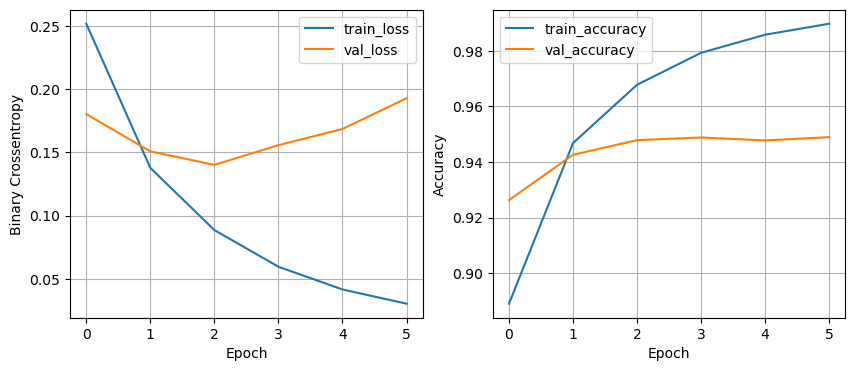

In [ ]:
import matplotlib.pyplot as plt

# plot the loss
def plot_loss(ax, history):
    ax.plot(history.history['loss'], label='Train Loss', color='blue')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Binary Crossentropy')
    ax.set_title('Loss Over Epochs')
    ax.grid(True)
    ax.legend()

#  plot the accuracy
def plot_accuracy(ax, history):
    ax.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Over Epochs')
    ax.grid(True)
    ax.legend()

# subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# apply functions
plot_loss(ax1, history)
plot_accuracy(ax2, history)

# display the plots
plt.tight_layout()
plt.show()



In [ ]:
# predict
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1, )

2466/2466 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step


In [ ]:


# loss & accuracy
loss, accuracy = model.evaluate(X_test, y_test)


2466/2466 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9460 - loss: 0.1434
 Model with Embedding: 
 Loss on test set: 0.14300478994846344 
 Accuracy on test set: 0.9467499852180481 | 94.67% 


In [ ]:

# Save the model
model.save('nn_model.keras')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:


# Load the saved model and tokeniser
loaded_model = tf.keras.models.load_model('nn_model.keras')
with open('tokenizer.pickle', 'rb') as handle:
    loaded_vectorizer = pickle.load(handle)



c:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import gradio as gr
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('nn_model.keras')

# Define the prediction function
def predict(text):
    try:
        # Step 1: Preprocess the text
        preprocessed_text = preprocess_text(text)

        # Step 2: Tokenise the text
        input_data = tf.convert_to_tensor([preprocessed_text], dtype=tf.string)

        # Step 3: Make a prediction using the model
        prediction = loaded_model.predict(input_data)

        # Debugging: Print the raw prediction probability
        print("Model prediction (raw):", prediction[0][0])

        # Step 4: Interpret the prediction
        result = "AI" if prediction[0][0] >= 0.5 else "Human"
        return result
    except Exception as e:
        return f"Error: {str(e)}"

# Create and launch the Gradio interface
interface = gr.Interface(fn=predict, inputs="text", outputs="text")
interface.launch(share=True)



c:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Model prediction (raw): 0.99294025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Model prediction (raw): 0.011877882


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
import gradio as gr
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('nn_model.keras')

# Define the prediction function
def predict(text):
    try:
        preprocessed_text = preprocess_text(text)
        input_data = tf.convert_to_tensor([preprocessed_text], dtype=tf.string)
        prediction = loaded_model.predict(input_data)
        result = "AI" if prediction[0][0] >= 0.5 else "Human"
        return result
    except Exception as e:
        return f"Error: {str(e)}"

# Create the Gradio interface
interface = gr.Interface(fn=predict, inputs="text", outputs="text")

# Start the Gradio interface locally
app = interface.launch(share=False)  # Set share=False to only run locally

# Start the ngrok tunnel to expose the app
public_url = ngrok.connect(7860)  # 7860 is the default port for Gradio
print(f"Public URL: {public_url}")

##  DistilBerta MODEL

In [ ]:
from sklearn.model_selection import train_test_split


# Determine the number of samples per category
n_per_category = 25000

# Perform stratified sampling
df_balanced_sample = df.groupby('label').apply(lambda x: x.sample(n=n_per_category, random_state=42)).reset_index(drop=True)

# Display the first few rows of the balanced sample
df_balanced_sample.head()

,text,label,cleaned_text
0,But the annual Easter School at St Mary's Univ...,0,annual easter school st mary university colleg...
1,Some people would say they get used to it. Oth...,0,people would say get used others say havent kn...
2,The topic of driveless cars is very controvers...,0,topic driveless car controversial people say d...
3,what classes do i take next semester? i ...,0,class take next semester need plan rest colleg...
4,We consider the k -server problem on trees and...,0,consider k server problem tree hsts give algor...


In [ ]:
from sklearn.model_selection import train_test_split
# Split the dataset into train and test sets
train_df1, test_df1 = train_test_split(df, test_size=0.2, random_state=42)

train_df_main = train_df1.reset_index(drop=True)
test_df_main = test_df1.reset_index(drop=True)

In [ ]:
#set batch size and max len
BATCH_SIZE = 16
MAX_LEN = 512

In [ ]:
import multiprocessing
import numpy as np
from tokenizers import Tokenizer, pre_tokenizers, trainers
from functools import partial

start = time.time()
# Example vocab size
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


def tokenise_and_pad(sentence, tokenizer, max_length):
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='np'
    )
    return {"input_ids": encoded['input_ids'].squeeze(),
           "attention_masks": encoded["attention_mask"].squeeze()}

# Function for parallel processing
def tokenise_and_pad_parallel(data, tokenizer, max_length):
    with multiprocessing.Pool() as pool:
        tokenized = pool.map(partial(tokenise_and_pad, tokenizer=tokenizer, max_length=max_length), data)
    return tokenized

# Apply tokenization and padding to all sentences in parallel
train_df_main['tokens'] = tokenise_and_pad_parallel(train_df_main['cleaned_text'], tokenizer, MAX_LEN)

print(train_df_main['tokens'][0])
print(train_df_main['label'][:4])

end = time.time()
print(f"time taken: {end-start}")

In [ ]:
from sklearn.model_selection import train_test_split

X = train_df_main['tokens'].values.tolist()
Y = train_df_main['label'].values

train_df_model, test_df_model = train_test_split(train_df_main, test_size=0.1, shuffle=True, random_state = 42)
train_df2 = train_df_model.reset_index()
test_df2 = test_df_model.reset_index()
print(train_df2)
print(test_df2)

         index                                               text  label  \
0       211007  [substeps] Children are notorious for being " ...      1   
1       222696  Southern California contains a Mediterranean c...      1   
2       127925  Community service is super important to the co...      1   
3       244246  Cam came online at 2140. Blasted lands, flat a...      0   
4       196313  Many times we as humans study things that have...      0   
...        ...                                                ...    ...   
254304  119879  I am a very vocal and outspoken person. I had ...      0   
254305  259178  When Steven Gerrard stepped out onto the field...      1   
254306  131932  HATE Nothing. DISLIKE Only location is far awa...      0   
254307  146867  Background of Nursing Practices Essay\n\nSumma...      0   
254308  121958  A first generation Tesla Model S was caught on...      0   

                                             cleaned_text  \
0       substeps child not

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 512

In [ ]:
vocab = tokenizer.get_vocab()
VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)

50265


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['label'].values
        self.tokens = dataframe['tokens'].values


    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.tokens[idx]['input_ids'])
        item['attention_masks'] = torch.tensor(self.tokens[idx]['attention_masks'])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = TextDataset(train_df2)
test_dataset = TextDataset(test_df2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE * torch.cuda.device_count(), shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = ('cuda'
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
          )

model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=1)
model = model.to(device)
print(model)

In [ ]:
start = time.time()
with torch.no_grad():
        for batch, data in enumerate(train_loader):
            inputs = data['input_ids'].pin_memory().to(device, non_blocking=True)
            attention_masks = data['attention_masks'].pin_memory().to(device, non_blocking=True)
            labels = data['labels'].pin_memory().to(device, non_blocking=True)
            pred = model(inputs, attention_mask = attention_masks)
            if batch == 1000:
                break
end = time.time()
print(end-start)

246.95818519592285


In [ ]:
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
def get_accuracy(pred,label):
    pred = (pred > 0.5).long()
    return torch.sum(pred == label).item()

In [ ]:
def train(dataloader, model, loss_fn, optimizer, train_losses, train_acc):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    accuracy = 0
    num_batches = len(dataloader)
    start = time.time()

    for batch, data in enumerate(dataloader):
        inputs = data['input_ids'].pin_memory().to(device, non_blocking=True)
        attention_masks = data['attention_masks'].pin_memory().to(device, non_blocking=True)
        labels = data['labels'].pin_memory().to(device, non_blocking=True)

        y = labels.float()  # Convert labels to float

        pred = model(inputs, attention_mask=attention_masks)
        pred = nn.Sigmoid()(pred.logits).squeeze(-1)

        loss = loss_fn(pred, y)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy += get_accuracy(pred, y)

        if batch % 100 == 0:
            end = time.time()
            loss, current = loss.item(), (batch + 1) * len(inputs)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]" + "                " + f"time taken: {(end-start):>5f} ")

    mean_loss = loss_sum / num_batches
    accuracy /= size
    train_losses.append(mean_loss)
    train_acc.append(accuracy)
    print(f"Training loss: {mean_loss:>7f}")
    print(f"Training accuracy: {(accuracy*100):>7f}")

In [ ]:
import torch


model_save_path = "model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to model.pth


In [ ]:
def test(dataloader, model, loss_fn, test_losses, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            inputs = data['input_ids'].pin_memory().to(device, non_blocking=True)
            attention_masks = data['attention_masks'].pin_memory().to(device, non_blocking=True)
            labels = data['labels'].pin_memory().to(device, non_blocking=True)

            y = labels.float()
            pred = model(inputs, attention_mask=attention_masks)
            pred = nn.Sigmoid()(pred.logits).squeeze(-1)



            test_loss += loss_fn(pred, y).item()
            correct += get_accuracy(pred, y)

    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)
    test_acc.append(correct)
    print(f"Test loss: {test_loss:>7f}")
    print(f"Test accuracy: {(correct*100):>7f}")

In [ ]:
# Save both model weights and optimizer state
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# Save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state.pth')

In [ ]:
torch.save({
    '/content/drive/MyDrive/model_state_dict': model.state_dict(),
    '/content/drive/MyDrive/optimizer_state_dict': optimizer.state_dict()
}, '/content/drive/MyDrive/checkpoint.pth')

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<ipython-input-25-6a13502e0520>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth')


In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.ipc_collect()

In [ ]:
# Load the saved state

start_epoch = 2

train_losses = []
test_losses = []
test_acc = []
train_acc = []

for i in range(start_epoch, start_epoch + 2):  # Train for 2 more epochs
    print(f'Epoch {i} -----------------------------------')
    train(train_loader, model, loss_func, optimizer, train_losses, train_acc)
    test(test_loader, model, loss_func, test_losses, test_acc)

    # Save the model after each epoch
    torch.save({
        'epoch': i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, f'model_epoch_{i}.pth')  # Save as .pth for checkpoints

Epoch 2 -----------------------------------
loss: 0.099289 [   32/568021]                time taken: 1.912150 
loss: 0.135432 [ 3232/568021]                time taken: 147.078437 
loss: 0.078790 [ 6432/568021]                time taken: 291.683736 
loss: 0.073379 [ 9632/568021]                time taken: 436.727731 
loss: 0.191876 [12832/568021]                time taken: 581.591965 
loss: 0.092914 [16032/568021]                time taken: 726.217976 
loss: 0.175083 [19232/568021]                time taken: 870.923065 
loss: 0.155204 [22432/568021]                time taken: 1015.981934 
loss: 0.235321 [25632/568021]                time taken: 1160.585533 
loss: 0.039132 [28832/568021]                time taken: 1305.301827 
loss: 0.094274 [32032/568021]                time taken: 1449.978213 
loss: 0.085507 [35232/568021]                time taken: 1594.812578 
loss: 0.212363 [38432/568021]                time taken: 1739.770476 
loss: 0.092368 [41632/568021]                time taken

In [ ]:
for data in train_loader:
    print(data['input_ids'].shape)
    break

for batch, (data) in enumerate(train_loader):
    print(data['input_ids'].shape)
    break

torch.Size([32, 512])
torch.Size([32, 512])


In [ ]:
test_df_main['id'] = range(1, len(test_df_main) + 1)

In [ ]:

size = df_filtered.shape

# Print the number of rows and columns
print(f"Number of rows: {size[0]}")
print(f"Number of columns: {size[1]}")

Number of rows: 148054
Number of columns: 4


In [ ]:
test_df_main['text_length'] = test_df_main['cleaned_text'].apply(lambda x: len(x.split()))

# Print the first few rows to verify
print(test_df_main[['cleaned_text', 'text_length']].head())

                                        cleaned_text  text_length
0  concept lesson life bully autobiography essay ...          556
1  carolina next possession fullback mike tolbert...          560
2  government like keep taxing people many way co...           35
3  nothing breaking seal doesnt actually exist al...           92
4  becca liked swim practiced everyday hour enter...          295


In [ ]:
# Find the maximum word count (longest text)
max_length = test_df_main['text_length'].max()

# Find the mean word count
mean_length = test_df_main['text_length'].mean()

print(f"Longest text has {max_length} words.")
print(f"Mean word count is {mean_length:.2f} words.")

Longest text has 16427 words.
Mean word count is 275.17 words.


In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = test_df_main['text_length'].quantile(0.25)
Q3 = test_df_main['text_length'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")


Lower bound for outliers: -366.0
Upper bound for outliers: 770.0


In [ ]:
# Filter out the outliers
df_filtered = test_df_main[(test_df_main['text_length'] >= lower_bound) & (test_df_main['text_length'] <= upper_bound)]

print(f"Original number of rows: {len(test_df_main)}")
print(f"Number of rows after removing outliers: {len(df_filtered)}")

Original number of rows: 157784
Number of rows after removing outliers: 148054


In [ ]:
# Recalculate the maximum word count (longest text) and mean word count
max_length_filtered = df_filtered['text_length'].max()
mean_length_filtered = df_filtered['text_length'].mean()

print(f"Longest text after removing outliers has {max_length_filtered} words.")
print(f"Mean word count after removing outliers is {mean_length_filtered:.2f} words.")

Longest text after removing outliers has 770 words.
Mean word count after removing outliers is 200.58 words.


In [ ]:
df_label_0 = df_filtered[df_filtered['label'] == 0]
df_label_1 = df_filtered[df_filtered['label'] == 1]

In [ ]:
df_label_0_sampled = df_label_0.sample(n=5000, random_state=42)
df_label_1_sampled = df_label_1.sample(n=5000, random_state=42)

In [ ]:
# Combine the sampled DataFrames
df_reduced = pd.concat([df_label_0_sampled, df_label_1_sampled])

# Shuffle the combined DataFrame to mix the labels
df_reduced = df_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check the distribution of labels in the reduced DataFrame
print(df_reduced['label'].value_counts())

label
1    5000
0    5000
Name: count, dtype: int64


In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the tokenizer for DistilRoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=1)

# Load the model's state dictionary
model_path = '/content/drive/MyDrive/model_epoch_3.pth'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model_state_dict = state_dict['model_state_dict']
model.load_state_dict(model_state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set the model to evaluation mode


def preprocess_function(examples):
    return tokenizer(examples['cleaned_text'], padding='max_length', max_length=512, truncation=True, return_tensors="pt")

# Tokenise all data in the DataFrame with max_length set to 512
encoded_data = df_reduced['cleaned_text'].apply(lambda x: preprocess_function({'cleaned_text': x}))

# Create a DataLoader with input_ids and attention_masks from the test dataset
eval_loader = DataLoader([{
    'input_ids': data['input_ids'].squeeze(0),
    'attention_mask': data['attention_mask'].squeeze(0)
} for data in encoded_data], batch_size=32, shuffle=False)

# Placeholder for model predictions
predictions = []

# Use tqdm to add a progress bar
with torch.no_grad():
    for data in tqdm(eval_loader, desc="Processing"):
        inputs = data['input_ids'].to(device)
        attention = data['attention_mask'].to(device)
        pred = model(inputs, attention_mask=attention)
        pred = nn.Sigmoid()(pred.logits).cpu().detach()
        predictions.extend(pred.numpy().tolist())

# Add predictions to the DataFrame
df_reduced["predicted_label"] = predictions


if "original_label" in df_reduced.columns:
    correct_predictions = (df_reduced["original_label"] == (df_reduced["predicted_label"] > 0.5)).sum()
    total_predictions = len(df_reduced)
    accuracy = correct_predictions / total_predictions

    print(f"Accuracy: {accuracy:.2f}")


    comparison_df = df_reduced[["id", "original_label", "predicted_label"]]
    print(comparison_df.head())

    # Save the comparison DataFrame to CSV
    comparison_df.to_csv("comparison_df.csv", index=False)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-0d7b31ca46ed>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

In [ ]:
# Flatten the predictions
predictions = [p[0] if isinstance(p, list) else p for p in predictions]

# Convert predictions to binary labels (0 or 1)
df_reduced["predicted_label"] = [1 if p > 0.5 else 0 for p in predictions]

Accuracy: 0.92
   id  label  predicted_label
0   1      1                1
1   2      0                0
2   3      0                0
3   4      0                0
4   5      0                1


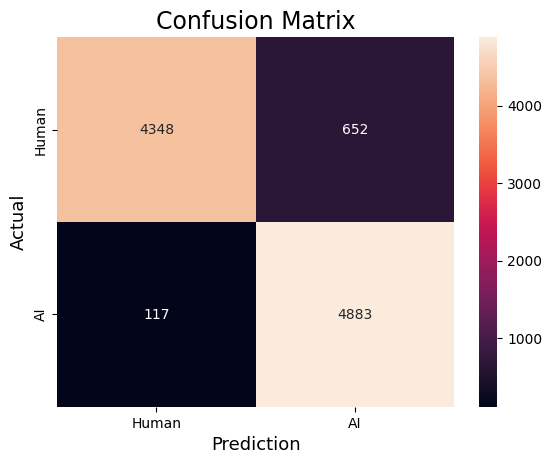

              precision    recall  f1-score   support

       Human       0.97      0.87      0.92      5000
          AI       0.88      0.98      0.93      5000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



In [ ]:

if "label" in df_reduced.columns:
    correct_predictions = (df_reduced["label"] == df_reduced["predicted_label"]).sum()
    total_predictions = len(df_reduced)
    accuracy = correct_predictions / total_predictions

    print(f"Accuracy: {accuracy:.2f}")


    comparison_df = df_reduced[["id", "label", "predicted_label"]]
    print(comparison_df.head())

    # Save the comparison DataFrame to CSV
    comparison_df.to_csv("comparison_df.csv", index=False)

    # Generate the confusion matrix
    cm = confusion_matrix(df_reduced["label"], df_reduced["predicted_label"])

    # Plot the confusion matrix
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Human', 'AI'],
                yticklabels=['Human', 'AI'])
    plt.xlabel('Prediction', fontsize=13)
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17)
    plt.show()

    # Print the classification report
    print(classification_report(df_reduced["label"], df_reduced["predicted_label"], target_names=['Human', 'AI']))

In [ ]:
import pandas as pd


test_df_GPT = pd.read_excel('/content/drive/MyDrive/test_data_GPT4.xlsx')

# Display the first few rows of the dataframe
test_df_GPT.head()

,text,label
0,"The cat (Felis catus), also referred to as dom...",0
1,"Cats, scientifically known as Felis catus, are...",1
2,The dog (Canis familiaris or Canis lupus famil...,0
3,"Dogs, known scientifically as Canis lupus fami...",1
4,Pop music is a genre of popular music that ori...,0


In [ ]:
testText = [preprocess_text(text) for text in test_df_GPT['text']]


In [ ]:
test_df_GPT['processed_text'] = [preprocess_text(text) for text in test_df_GPT['text']]

In [ ]:
test_df_GPT.head()

,text,label,processed_text
0,"The cat (Felis catus), also referred to as dom...",0,cat felis catus also referred domestic cat hou...
1,"Cats, scientifically known as Felis catus, are...",1,cat scientifically known felis catus among bel...
2,The dog (Canis familiaris or Canis lupus famil...,0,dog canis familiaris canis lupus familiaris do...
3,"Dogs, known scientifically as Canis lupus fami...",1,dog known scientifically canis lupus familiari...
4,Pop music is a genre of popular music that ori...,0,pop music genre popular music originated moder...


In [ ]:
import torch
import torch.nn as nn


predicted_labels = []

for text in test_df_GPT['processed_text']:
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(device)

    # Predict the label
    with torch.no_grad():
        pred = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        pred = nn.Sigmoid()(pred.logits).cpu().detach().numpy()

    # Convert prediction to binary label
    predicted_label = 1 if pred[0] > 0.5 else 0
    predicted_labels.append(predicted_label)


test_df_GPT['predicted_label'] = predicted_labels

# Print
print(test_df_GPT.head())


                                                text  label  \
0  The cat (Felis catus), also referred to as dom...      0   
1  Cats, scientifically known as Felis catus, are...      1   
2  The dog (Canis familiaris or Canis lupus famil...      0   
3  Dogs, known scientifically as Canis lupus fami...      1   
4  Pop music is a genre of popular music that ori...      0   

                                      processed_text  predicted_label  
0  cat felis catus also referred domestic cat hou...                1  
1  cat scientifically known felis catus among bel...                1  
2  dog canis familiaris canis lupus familiaris do...                1  
3  dog known scientifically canis lupus familiari...                1  
4  pop music genre popular music originated moder...                0  


In [ ]:
correct_predictions = (test_df_GPT['predicted_label'] == test_df_GPT['label'])

# Calculate accuracy
accuracy = correct_predictions.mean()

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5833


In [ ]:
# rows where the prediction is incorrect
incorrect_predictions = test_df_GPT[test_df_GPT['predicted_label'] != test_df_GPT['label']]

# print incorrect predictions
print(incorrect_predictions)

                                                 text  label  \
0   The cat (Felis catus), also referred to as dom...      0   
2   The dog (Canis familiaris or Canis lupus famil...      0   
6   The Catholic Church, also known as the Roman C...      0   
8   \nHenry VI\nHenry VI of England\n\nFrom early ...      0   
10  Football is a family of team sports that invol...      0   

                                       processed_text  predicted_label  
0   cat felis catus also referred domestic cat hou...                1  
2   dog canis familiaris canis lupus familiaris do...                1  
6   catholic church also known roman catholic chur...                1  
8   henry vi henry vi england early childhood henr...                1  
10  football family team sport involve varying deg...                1  


## XLNET

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from datasets import load_metric

X = balanced_dataset['cleaned_text']
y = balanced_dataset['label']

# Combine them into a single DataFrame
df_combined = pd.DataFrame({'text': X, 'label': y})

# Split the data into train and test sets
train_df, test_df = train_test_split(df_combined, test_size=0.1, random_state=42, stratify=df_combined['label'])

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


def tokenise_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,   # Truncate sequences longer than max_length
        padding=False,     # Padding will be handled dynamically later
        max_length=256     # Cap sequences at 256 tokens
    )

train_dataset = train_dataset.map(tokenise_function, batched=True)
test_dataset = test_dataset.map(tokenise_function, batched=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load the pretrained XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Move the model to the device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the accuracy metric from the datasets library
accuracy_metric = load_metric("accuracy")

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"eval_accuracy": accuracy}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',  # Evaluate every epoch
    save_strategy='epoch',  # Save the model every epoch
    per_device_train_batch_size=4,  # Minimized batch size
    per_device_eval_batch_size=4,   # Minimized batch size
    gradient_accumulation_steps=16,  # Further increase gradient accumulation steps
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    save_total_limit=3,  # Only keep the last 3 checkpoints
    load_best_model_at_end=True,  # Load the best model when finished
    metric_for_best_model="eval_accuracy",  # Use eval_accuracy as the metric for selecting the best model
    logging_first_step=True,
    report_to="tensorboard",
    fp16=True,  # Enable mixed precision training for faster training
)

# initialise the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

#train
trainer.train()


Map:   0%|          | 0/63576 [00:00<?, ? examples/s]

Map:   0%|          | 0/7064 [00:00<?, ? examples/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
0,0.226200,0.217064,0.899349
1,0.146400,0.317559,0.881795
2,0.107100,0.359530,0.881087
3,0.102000,0.320536,0.912373
4,0.028700,0.460678,0.906569
5,0.037400,0.414491,0.906144
6,0.012000,0.443150,0.906002
8,0.013000,0.429702,0.911665
9,0.009900,0.496155,0.913364


TrainOutput(global_step=9930, training_loss=0.0832274560733114, metrics={'train_runtime': 20553.4133, 'train_samples_per_second': 30.932, 'train_steps_per_second': 0.483, 'total_flos': 8.782834314126418e+16, 'train_loss': 0.0832274560733114, 'epoch': 9.996224990562476})

#### Test XLNET learning rates

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from datasets import load_metric

X = balanced_dataset['cleaned_text']
y = balanced_dataset['label']

df_combined = pd.DataFrame({'text': X, 'label': y})

train_df, test_df = train_test_split(df_combined, test_size=0.1, random_state=42, stratify=df_combined['label'])

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


def tokenise_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=False,
        max_length=256
    )

train_dataset = train_dataset.map(tokenise_function, batched=True)
test_dataset = test_dataset.map(tokenise_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"eval_accuracy": accuracy}

learning_rates = [1e-5, 3e-5, 5e-5, 1e-4]
best_accuracy = 0
best_lr = None

for lr in learning_rates:
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=16,
        num_train_epochs=5,
        weight_decay=0.01,
        learning_rate=lr,
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        logging_first_step=True,
        report_to="tensorboard",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()

    eval_result = trainer.evaluate()
    accuracy = eval_result['eval_accuracy']

    print(f"Learning Rate: {lr}, Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"Best Learning Rate: {best_lr}, Best Accuracy: {best_accuracy}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Map:   0%|          | 0/39735 [00:00<?, ? examples/s]

Map:   0%|          | 0/4415 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-24e0652093fe>:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
0,0.290400,0.353249,0.832616
1,0.261400,0.447899,0.829898
2,0.203900,0.395889,0.853907
3,0.172500,0.406878,0.859117
4,0.129900,0.443165,0.861608


Learning Rate: 1e-05, Accuracy: 0.861608154020385


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
0,0.172800,0.476981,0.836920
1,0.134900,0.486621,0.857758
2,0.061400,0.671406,0.852548
3,0.062400,0.587283,0.873160
4,0.027100,0.638738,0.883126


Learning Rate: 3e-05, Accuracy: 0.8831257078142696


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
0,0.075500,0.441339,0.890600
1,0.065700,0.439725,0.896716
2,0.023200,0.698267,0.873613
3,0.031000,0.730243,0.879728
4,0.009300,0.837968,0.881993


Learning Rate: 5e-05, Accuracy: 0.8967157417893544


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
0,0.117200,0.465437,0.872027
1,0.094700,0.583748,0.865232
2,0.048600,0.371200,0.914609
3,0.016000,0.510500,0.910306
4,0.002600,0.641578,0.897395


Learning Rate: 0.0001, Accuracy: 0.9146092865232163
Best Learning Rate: 0.0001, Best Accuracy: 0.9146092865232163


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix



# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define a simple neural network model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=y_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_split=0.2)

# Find the best performing epoch
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch + 1}")

# Print out all metrics for the best performing epoch
best_metrics = {
    "val_loss": history.history['val_loss'][best_epoch],
    "val_accuracy": history.history['val_accuracy'][best_epoch],
    "train_loss": history.history['loss'][best_epoch],
    "train_accuracy": history.history['accuracy'][best_epoch]
}

print(f"Metrics for Best Epoch {best_epoch + 1}:")
for key, value in best_metrics.items():
    print(f"{key}: {value}")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print(classification_report(y_test_classes, y_pred_classes))
print(confusion_matrix(y_test_classes, y_pred_classes))

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8051 - loss: 0.3844 - val_accuracy: 0.8695 - val_loss: 0.2707
Epoch 2/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8880 - loss: 0.2465 - val_accuracy: 0.8829 - val_loss: 0.2502
Epoch 3/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9148 - loss: 0.1992 - val_accuracy: 0.8874 - val_loss: 0.2439
Epoch 4/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9296 - loss: 0.1686 - val_accuracy: 0.8893 - val_loss: 0.2485
Epoch 5/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9391 - loss: 0.1465 - val_accuracy: 0.8930 - val_loss: 0.2502
Epoch 6/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9483 - loss: 0.1280 - val_accuracy: 0.8939 - val_loss: 0.2533
Epoch 7/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9551 - loss: 0.1128 - val_accuracy: 0.8933 - val_loss: 0.2735
Epoch 8/1000
3533/3533 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9598 -

# Evaluation Metrics Summary

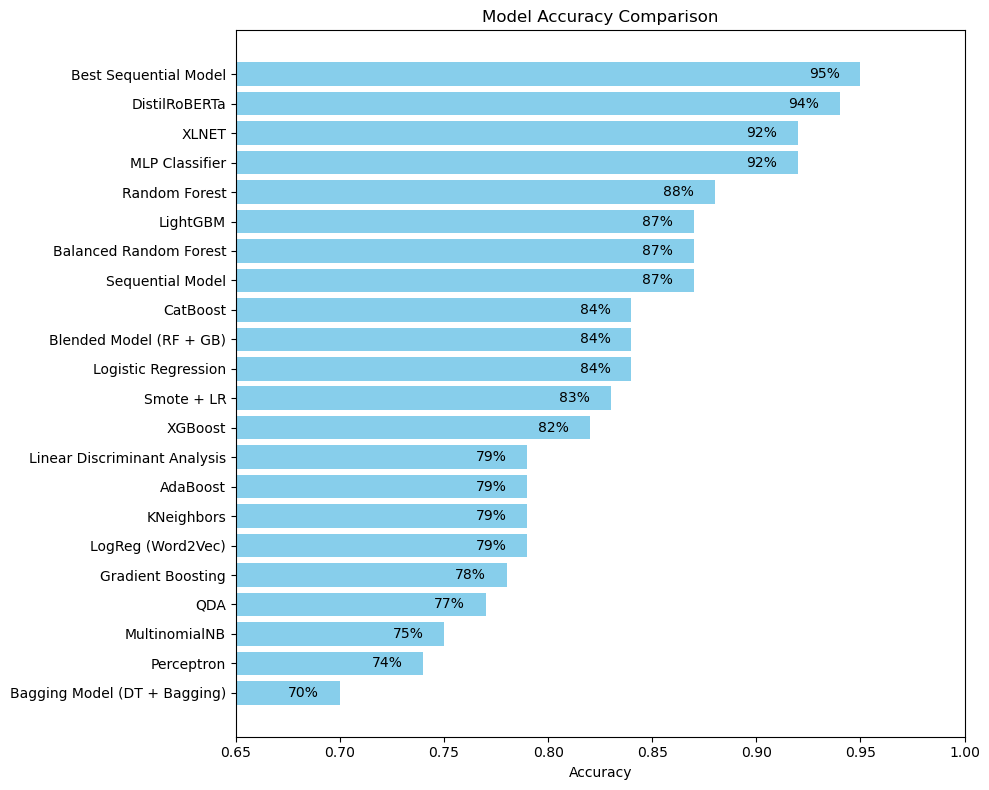

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
data = {
    'Classification Algorithm': [
        "Bagging Model (DT + Bagging)", "Perceptron", "MultinomialNB", "QDA",
        "Gradient Boosting", "LogReg (Word2Vec)", "KNeighbors", "AdaBoost",
        "Linear Discriminant Analysis", "XGBoost", "Smote + LR",
        "Logistic Regression", "Blended Model (RF + GB)", "CatBoost",
        "Sequential Model", "Balanced Random Forest", "LightGBM", "Random Forest",
        "MLP Classifier", "XLNET", "DistilRoBERTa", "Best Sequential Model"
    ],
    'Accuracy': [
        0.7, 0.74, 0.75, 0.77, 0.78, 0.79, 0.79, 0.79, 0.79, 0.82, 0.83, 0.84, 0.84,
        0.84, 0.87, 0.87, 0.87, 0.88, 0.92, 0.92, 0.94, 0.95
    ]
}

df = pd.DataFrame(data)

# Plot the bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(df['Classification Algorithm'], df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.65, 1)

# Add the percentage labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.01, bar.get_y() + bar.get_height()/2, f'{int(width * 100)}%',
             va='center', ha='right', color='black')

# Display the chart
plt.tight_layout()
plt.show()
